# DKL with Mixed Models

Here we use mixed models as neural-net initializers to the GP layer. The mixed models combine ICCD image data with the PLD parameters. 
The first case explores the "MixedICCDNet" which combines (2+1)D CNN to analyse the image sequence and this outputs are concatenated with the an MLP layer that processes the PLD parameters.

The second uses a RCNN based mixed network. Here the image sequences are analysed using a LSTM network and then combined with the processed inputs of the PLD parameters. 

# Imports

In [ ]:
import matplotlib.pylab as plt
import numpy as np

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, ConcatDataset


# Import GP and BoTorch functions
import gpytorch as gpt
import pandas as pd
from botorch.models import SingleTaskGP, ModelListGP

#from botorch.models import gpytorch
# from botorch.fit import fit_gpytorch_model
from botorch.models.gpytorch import GPyTorchModel
from botorch.utils import standardize
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel, PeriodicKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods.likelihood import Likelihood
from gpytorch.constraints import GreaterThan
from gpytorch.models import ExactGP
from mpl_toolkits.axes_grid1 import make_axes_locatable

# from smt.sampling_methods import LHS
from torch.optim import SGD
from torch.optim import Adam
from scipy.stats import norm

In [3]:

from GP_functions import *
from custom_models import *
from ICCD_Dataset import *
from Plot_DKL_predictions import *


# Functions

In [4]:

def norm_0to1_tensor(X):

    norm_tensor = torch.empty_like(X)

    for i in range(X.shape[-1]):
        torch_i = X[:, i]
        norm_i = (torch_i - torch.min(torch_i))/(torch.max(torch_i) - torch.min(torch_i))
        norm_tensor[:, i] = norm_i
           
    return norm_tensor

def extract_data(dataloader, norm = True):
    images = []
    params =[]
    scores = []
    indices = []

    for i, (images_i, params_i, score_i) in enumerate(dataloader):

        
        images.append(images_i)
        params.append(params_i)
        scores.append(score_i)

        indices.append(i)

    
    

    images = torch.cat(images, axis=0)
    params = torch.cat(params, axis=0)
    scores = torch.cat(scores, axis=0)
    indices = np.array(indices)
    

    if norm:
        params = norm_0to1_tensor(params)
        scores = norm_0to1_tensor(scores)

    return images, params, scores, indices


def append_to_train(X, y, params, X_train, y_train, train_params, train_indices, ind):
    X_train = torch.cat((X_train, X[ind:ind+1]), axis=0)
    y_train = torch.cat((y_train, y[ind:ind+1]), axis=0)
    train_params = torch.cat((train_params, params[ind:ind+1]), axis=0)
    train_indices = np.hstack((train_indices, ind))

    return X_train, y_train, train_params, train_indices

def plot_training_loss(training_loss, testing_loss):
    plt.figure(figsize = (4,4))
    plt.semilogy(training_loss, label = 'Train Loss')
    plt.semilogy(testing_loss, label = 'Test Loss')
    plt.ylabel("Epoch loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    
    



# Get dataset

In [ ]:
datafile = 'data/PLD data.json'

# Get the raw dataset, wo transforms
dataset1 = ICCDDataset(datafile)


# Define the transform1
transform = transforms.RandomAffine(180,
                                    translate=(0.1,0.1),
                                    shear=10,
                                    scale=(0.8,1.2))
# Define the dataset with the transform
dataset2 = ICCDDataset(datafile, transform = transform)


# Define the transform with Gaussian noise
transform_with_noise = transforms.Compose([
    transforms.RandomAffine(180, translate=(0.1, 0.1), shear=10, scale=(0.8, 1.2)),
    AddGaussianNoise(mean=0.0, std=0.1)
])

# Define the noise for parameters
param_noise = AddGaussianNoise(mean=0.0, std=0.1)

# Define the dataset with the transform and noise
dataset3 = ICCDDataset(datafile, transform=transform_with_noise, params_noise=param_noise)


# Combine the datsets
dataset = ConcatDataset([dataset1, dataset2, dataset3])
print("dataset size:",len(dataset))


dataset size: 127


In [6]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

X, orig_params, score, _ = extract_data(dataloader, norm = False)

X, params, y, indices = extract_data(dataloader)




Split data to train and test set

In [7]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, indices, test_size=0.8, random_state=24)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)
test_dataset = TrainDataset(test_X, test_params, test_y, transform = None)

torch.Size([25, 1, 50, 40, 40]) torch.Size([25, 1]) torch.Size([102, 1, 50, 40, 40]) torch.Size([102, 1])


# 1. DKL with Mixed-CNN

## Single step training

In [104]:
from custom_models import DKL_Custom_nn, MLP, ICCDNet, MixedICCDNet

In [ ]:
custom_nn = MixedICCDNet(output_dim = 16) # This is a mixed model using (2+1)D CNN

latent_dim: 2


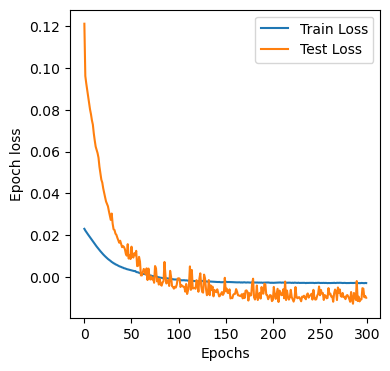

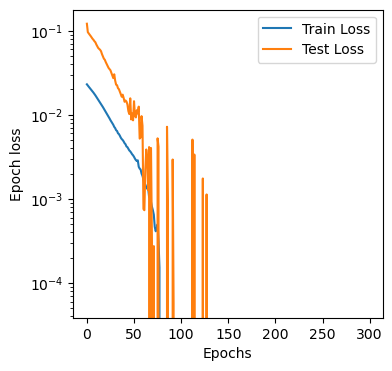

latent_dim: 3


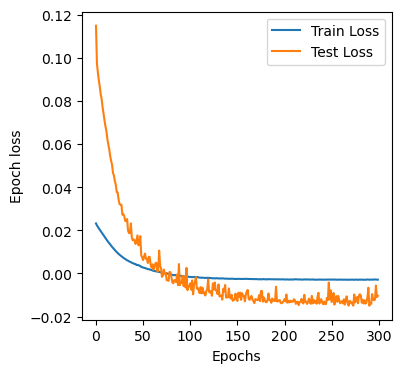

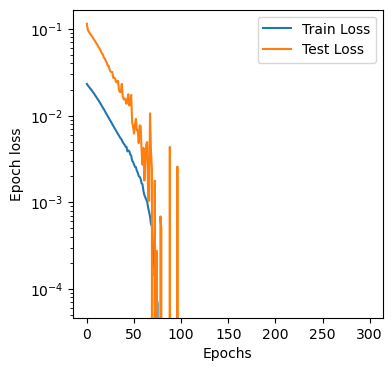

latent_dim: 6


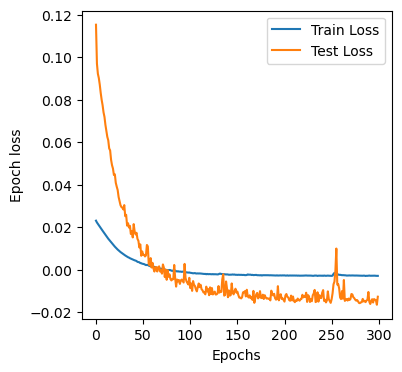

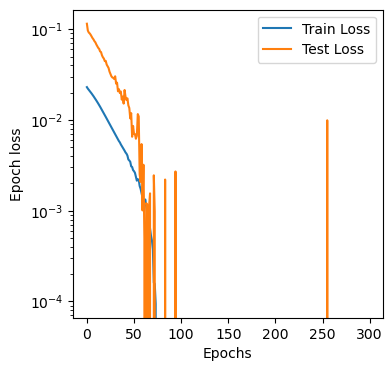

latent_dim: 8


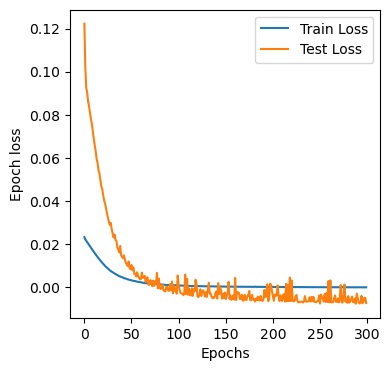

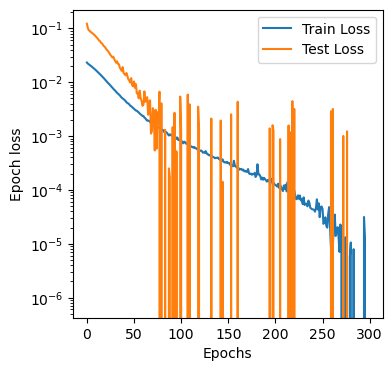

latent_dim: 10


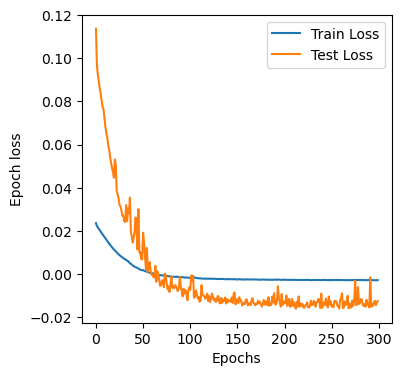

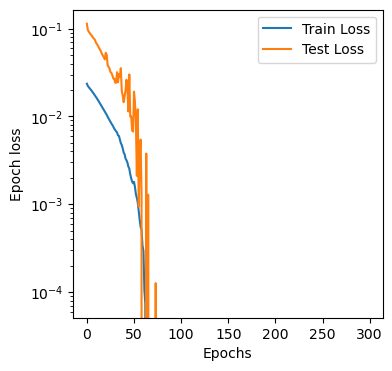

latent_dim: 16


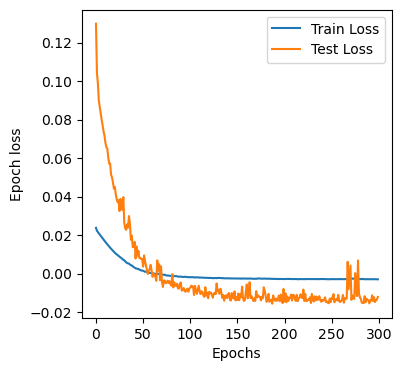

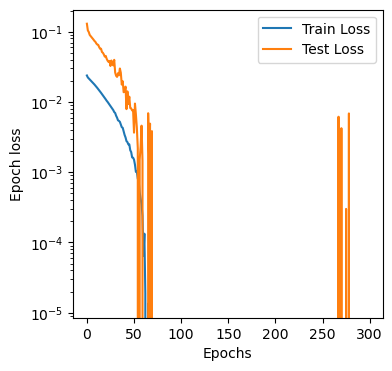

In [ ]:
latent_dims = [2, 3, 6, 8, 10, 16]  # Train over a range of latent dims.
n_epochs = 300
J_train = []
J_val = []

for latent_dim in latent_dims:

    train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, indices, test_size=0.2, random_state=24)


    train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)
    test_dataset = TrainDataset(test_X, test_params, test_y, transform = None)
    custom_nn = MixedICCDNet(output_dim = latent_dim)  

    print("latent_dim:", latent_dim)                                                                                                           
    model, training_loss, test_loss = train_test_mixed_nn_DKL(train_dataset, test_dataset, custom_nn, lr_custom_nn = 0.01, lr_gp = 0.01, num_epochs = n_epochs, plot_loss = True, n_batches = 8, weight_decay = 0)
    J_train.append(training_loss), J_val.append(test_loss)
    plot_training_loss(training_loss, test_loss)
        
                                                                                                          
               

Analyse train and val loss

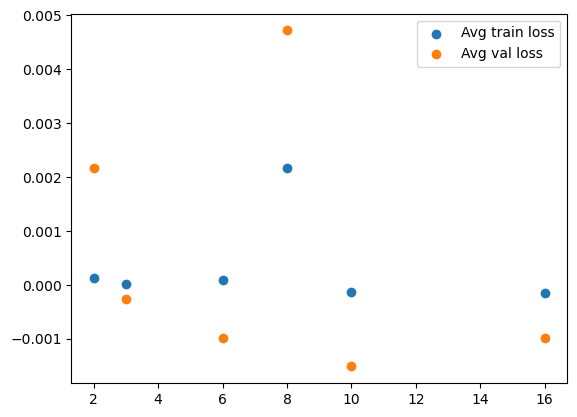

In [67]:
J_train = np.asarray(J_train)
J_val = np.asarray(J_val)

j_train = J_train[:, 0:].mean(axis = -1)
j_val = J_val[:, 0:].mean(axis = -1)

plt.scatter(latent_dims, j_train, label = "Avg train loss")
plt.scatter(latent_dims, j_val, label = "Avg val loss")
plt.legend()
plt.show()

## Active learning loop

In [8]:
train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, 
                                                                                                           indices, 
                                                                                                           test_size=0.8, 
                                                                                                           random_state=24)

initial_trainsize = train_indices.shape[0]

train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)

print(len(train_dataset))


n_epochs = 500
n_batches = 4
sample_next_points = 3
beta = 0
lr_custom_nn = 0.01
lr_gp = 0.01
initial_test_fraction = 0.8
random_state = 24


#Set the number of exploration steps
exploration_steps = 10

latent_dims = [3, 6, 10, 16]


expt_name = "5_Mixed_ICCD"
save_folder = os.path.join("data", expt_name)
os.makedirs(save_folder, exist_ok=True)


76



------------------Latent_dim:3	Exploration Step:1 ----------------------- 
76


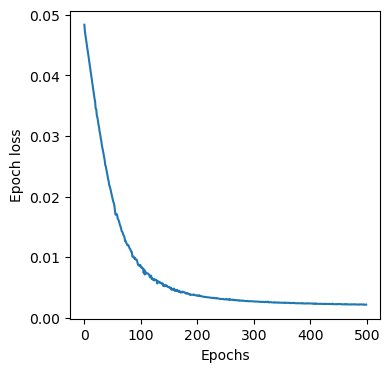

training_loss 0.002171814387861181
Average pos.mean:0.1528552621603012, Average pos_var: 0.0002941190905403346
(79,)

------------------Latent_dim:3	Exploration Step:2 ----------------------- 
79


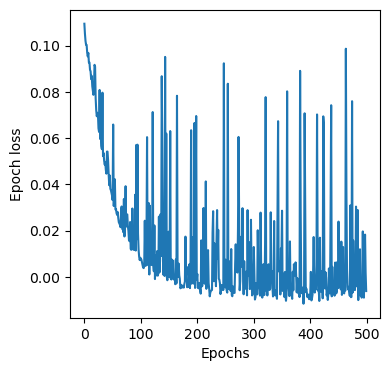

training_loss -0.006116198831222487
Average pos.mean:0.1712113469839096, Average pos_var: 0.0004347189678810537
(82,)

------------------Latent_dim:3	Exploration Step:3 ----------------------- 
82


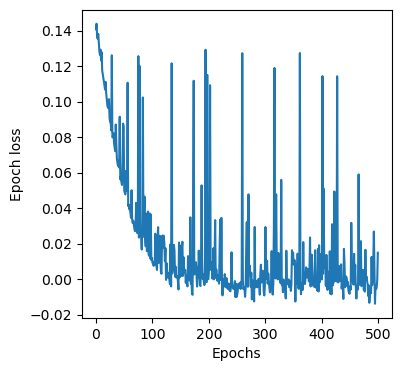

training_loss 0.014853378615200457
Average pos.mean:0.171636164188385, Average pos_var: 0.02063865028321743
(85,)

------------------Latent_dim:3	Exploration Step:4 ----------------------- 
85


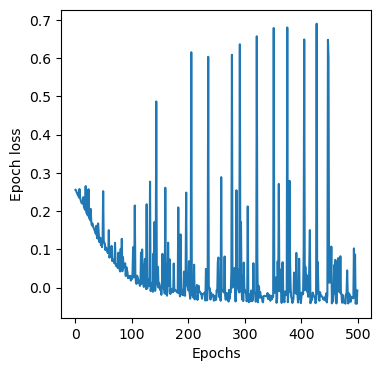

training_loss -0.007461885669439691
Average pos.mean:0.18725942075252533, Average pos_var: 0.0008548861951567233
(88,)

------------------Latent_dim:3	Exploration Step:5 ----------------------- 
88


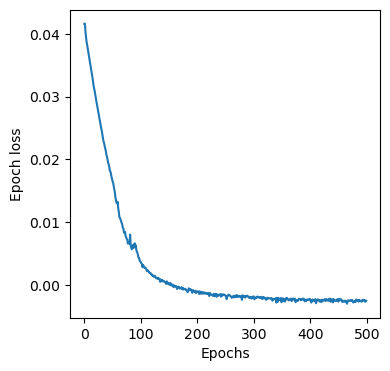

training_loss -0.002464442238567013
Average pos.mean:0.15142910182476044, Average pos_var: 0.00894394051283598
(91,)

------------------Latent_dim:3	Exploration Step:6 ----------------------- 
91


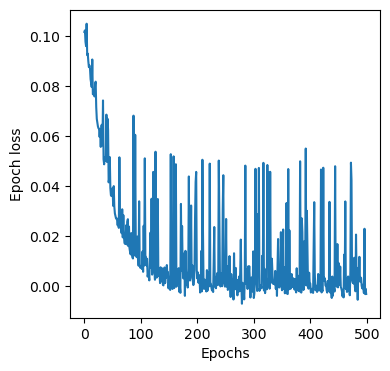

training_loss -0.0030547203388851425
Average pos.mean:0.13708297908306122, Average pos_var: 0.022703012451529503
(94,)

------------------Latent_dim:3	Exploration Step:7 ----------------------- 
94


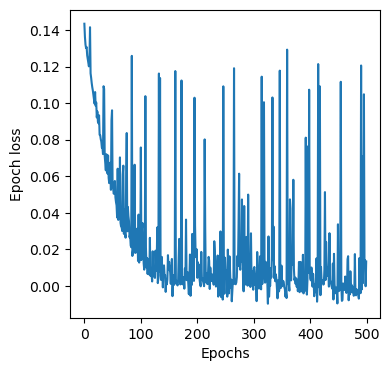

training_loss 0.01328292767244425
Average pos.mean:0.23481959104537964, Average pos_var: 0.026837939396500587
(97,)

------------------Latent_dim:3	Exploration Step:8 ----------------------- 
97


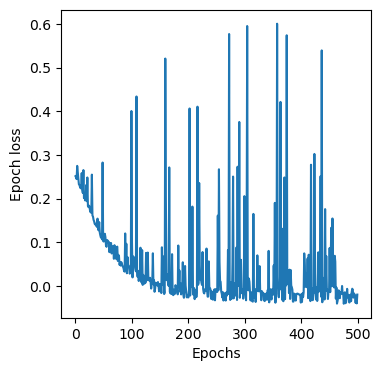

training_loss -0.02021696528820873
Average pos.mean:0.14763902127742767, Average pos_var: 0.0009620005148462951
(100,)

------------------Latent_dim:3	Exploration Step:9 ----------------------- 
100


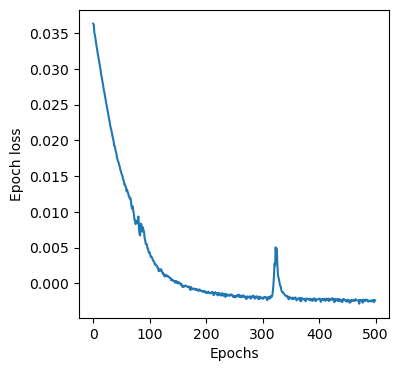

training_loss -0.002351253479530308
Average pos.mean:0.20088869333267212, Average pos_var: 0.01035140361636877
(103,)

------------------Latent_dim:3	Exploration Step:10 ----------------------- 
103


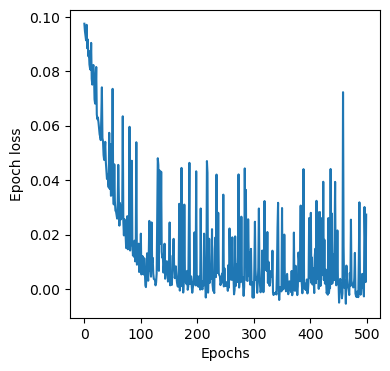

training_loss 0.02733765085757544
Average pos.mean:0.23158392310142517, Average pos_var: 0.030129965394735336
(106,)
Intitial_dataset_score: tensor(93.2249)


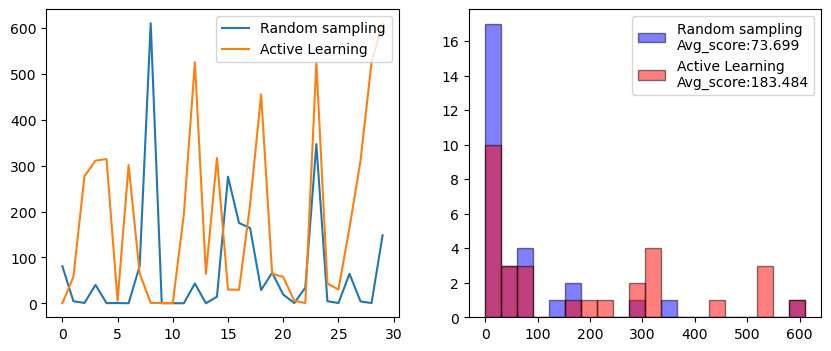


------------------Latent_dim:6	Exploration Step:1 ----------------------- 
76


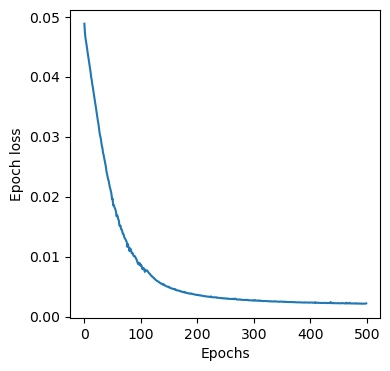

training_loss 0.0022132587948694464
Average pos.mean:0.15061357617378235, Average pos_var: 0.0003058518632315099
(79,)

------------------Latent_dim:6	Exploration Step:2 ----------------------- 
79


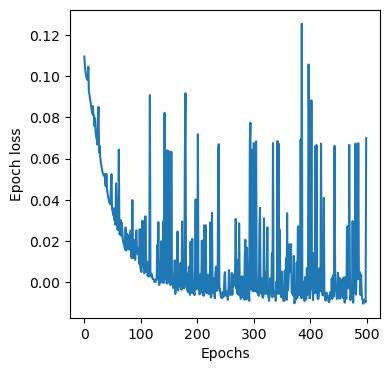

training_loss 0.06993399669905878
Average pos.mean:0.14297395944595337, Average pos_var: 0.00044334071571938694
(82,)

------------------Latent_dim:6	Exploration Step:3 ----------------------- 
82


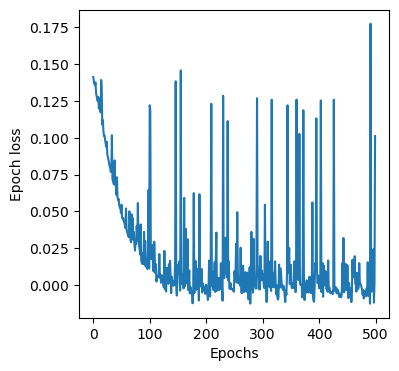

training_loss 0.10113656967388229
Average pos.mean:0.26412317156791687, Average pos_var: 0.02309017814695835
(85,)

------------------Latent_dim:6	Exploration Step:4 ----------------------- 
85


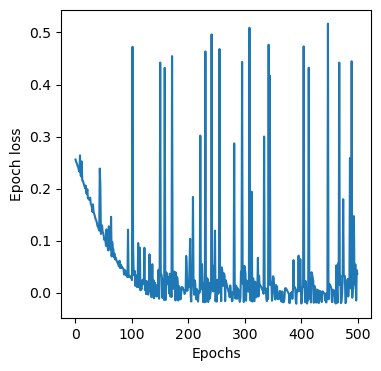

training_loss 0.03651233571801869
Average pos.mean:0.2132325917482376, Average pos_var: 0.028099212795495987
(88,)

------------------Latent_dim:6	Exploration Step:5 ----------------------- 
88


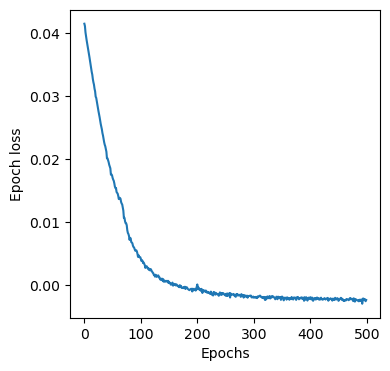

training_loss -0.0023741630652100412
Average pos.mean:0.21486324071884155, Average pos_var: 0.010206717066466808
(91,)

------------------Latent_dim:6	Exploration Step:6 ----------------------- 
91


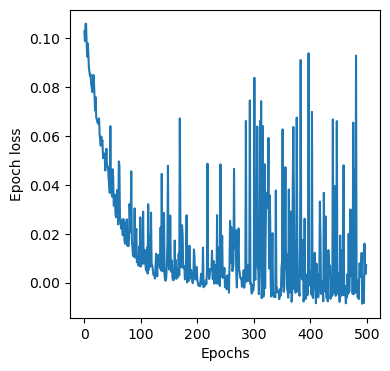

training_loss 0.007127512607416532
Average pos.mean:0.17138347029685974, Average pos_var: 0.0012657950865104795
(94,)

------------------Latent_dim:6	Exploration Step:7 ----------------------- 
94


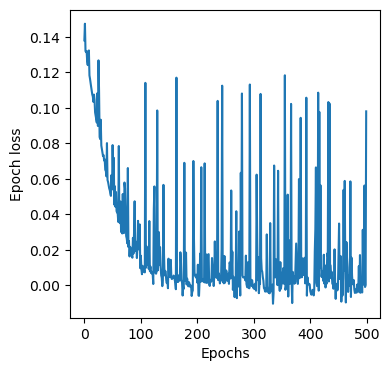

training_loss 0.09800523407097464
Average pos.mean:0.2653082013130188, Average pos_var: 0.029827773571014404
(97,)

------------------Latent_dim:6	Exploration Step:8 ----------------------- 
97


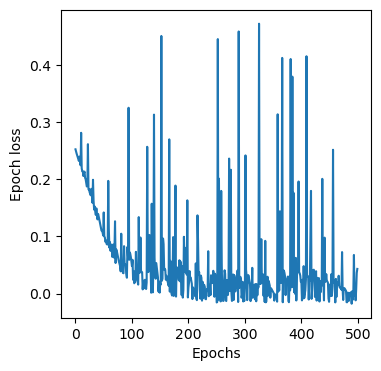

training_loss 0.04314649257583676
Average pos.mean:0.22850440442562103, Average pos_var: 0.030581312254071236
(100,)

------------------Latent_dim:6	Exploration Step:9 ----------------------- 
100


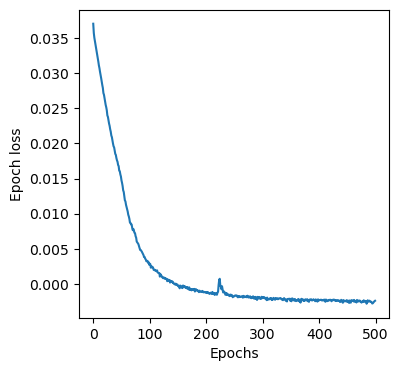

training_loss -0.0024067863215642975
Average pos.mean:0.17231504619121552, Average pos_var: 0.009536162950098515
(103,)

------------------Latent_dim:6	Exploration Step:10 ----------------------- 
103


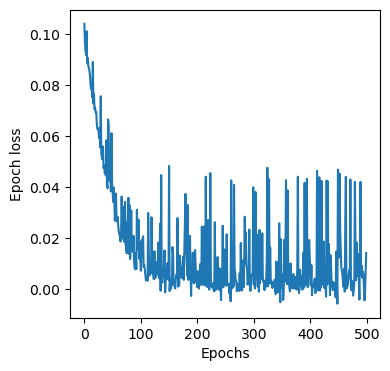

training_loss 0.014181336378758031
Average pos.mean:0.16058219969272614, Average pos_var: 0.03169737011194229
(106,)
Intitial_dataset_score: tensor(93.2249)


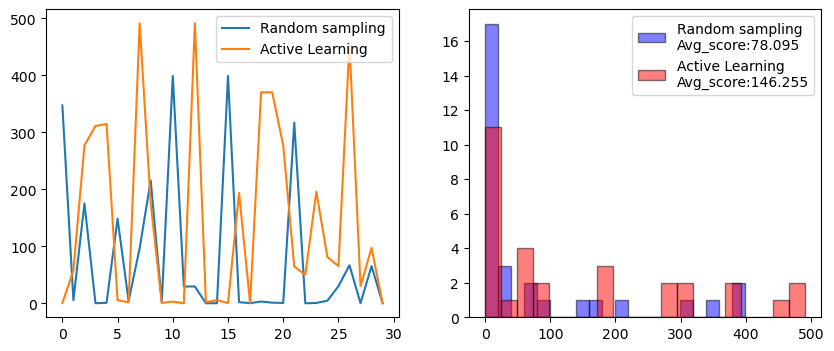


------------------Latent_dim:10	Exploration Step:1 ----------------------- 
76


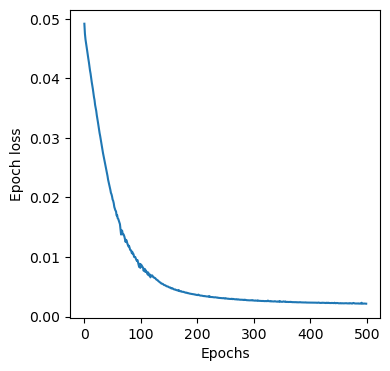

training_loss 0.00215538544570704
Average pos.mean:0.15278062224388123, Average pos_var: 0.0003064788761548698
(79,)

------------------Latent_dim:10	Exploration Step:2 ----------------------- 
79


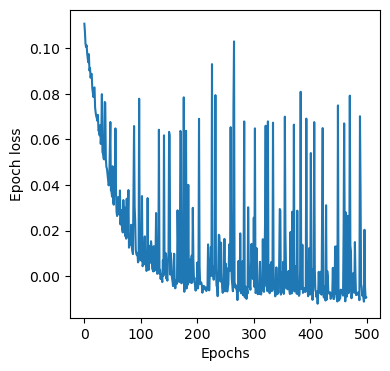

training_loss -0.00926739522198696
Average pos.mean:0.15031009912490845, Average pos_var: 0.00043925983482040465
(82,)

------------------Latent_dim:10	Exploration Step:3 ----------------------- 
82


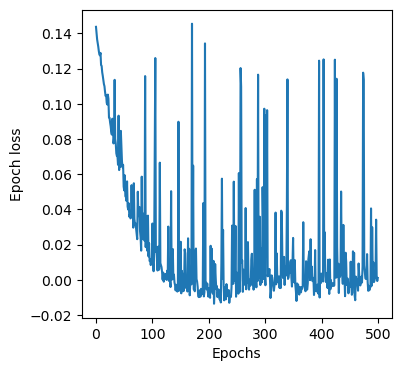

training_loss 0.0010568978219574932
Average pos.mean:0.16303527355194092, Average pos_var: 0.022895893082022667
(85,)

------------------Latent_dim:10	Exploration Step:4 ----------------------- 
85


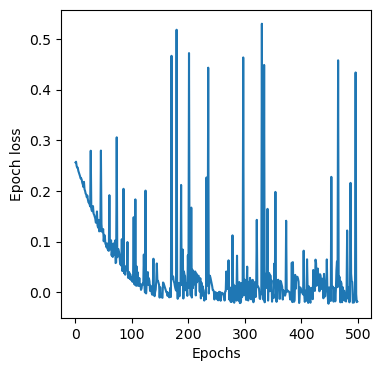

training_loss -0.018591389210767216
Average pos.mean:0.27562135457992554, Average pos_var: 0.02691647969186306
(88,)

------------------Latent_dim:10	Exploration Step:5 ----------------------- 
88


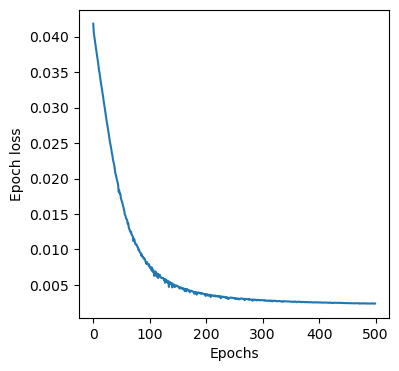

training_loss 0.0023753501340102587
Average pos.mean:0.1682237684726715, Average pos_var: 0.00023135780065786093
(91,)

------------------Latent_dim:10	Exploration Step:6 ----------------------- 
91


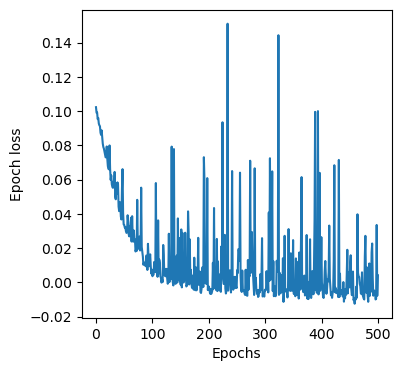

training_loss 0.004174352797641921
Average pos.mean:0.16542671620845795, Average pos_var: 0.0005020454409532249
(94,)

------------------Latent_dim:10	Exploration Step:7 ----------------------- 
94


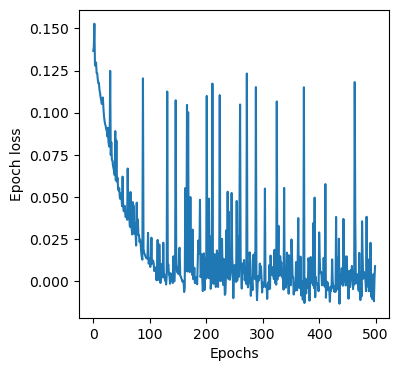

training_loss 0.008919744428734487
Average pos.mean:0.1906212866306305, Average pos_var: 0.022428762167692184
(97,)

------------------Latent_dim:10	Exploration Step:8 ----------------------- 
97


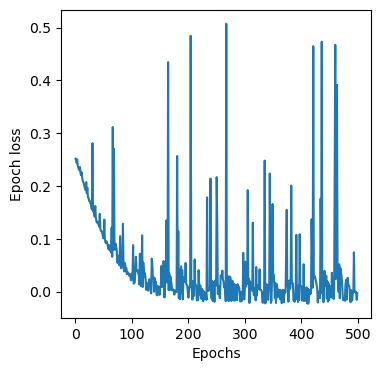

training_loss -0.0032505121531303345
Average pos.mean:0.13113300502300262, Average pos_var: 0.024537619203329086
(100,)

------------------Latent_dim:10	Exploration Step:9 ----------------------- 
100


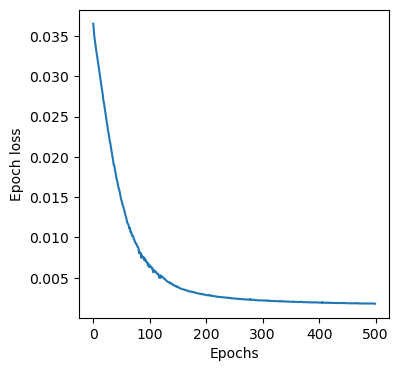

training_loss 0.0017840264531315032
Average pos.mean:0.17304766178131104, Average pos_var: 0.0002496419765520841
(103,)

------------------Latent_dim:10	Exploration Step:10 ----------------------- 
103


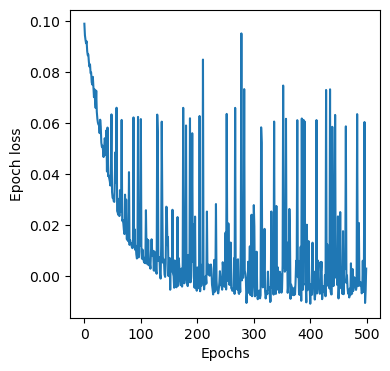

training_loss 0.0030768061604770553
Average pos.mean:0.19687432050704956, Average pos_var: 0.010462689213454723
(106,)
Intitial_dataset_score: tensor(93.2249)


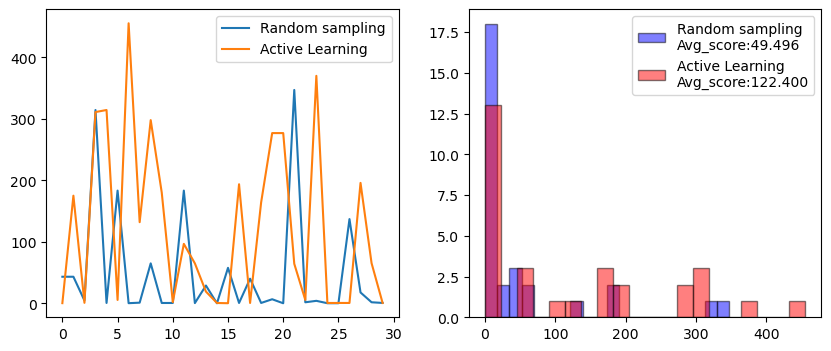


------------------Latent_dim:16	Exploration Step:1 ----------------------- 
76


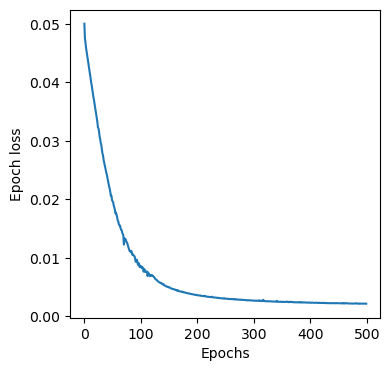

training_loss 0.0021636453234357197
Average pos.mean:0.15275491774082184, Average pos_var: 0.00031146875699050725
(79,)

------------------Latent_dim:16	Exploration Step:2 ----------------------- 
79


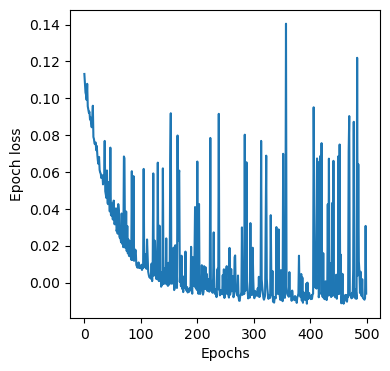

training_loss -0.006011980246829559
Average pos.mean:0.14687366783618927, Average pos_var: 0.0004621576808858663
(82,)

------------------Latent_dim:16	Exploration Step:3 ----------------------- 
82


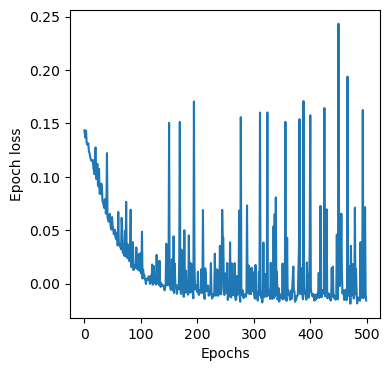

training_loss -0.01592387434410659
Average pos.mean:0.15952403843402863, Average pos_var: 0.0005486205336637795
(85,)

------------------Latent_dim:16	Exploration Step:4 ----------------------- 
85


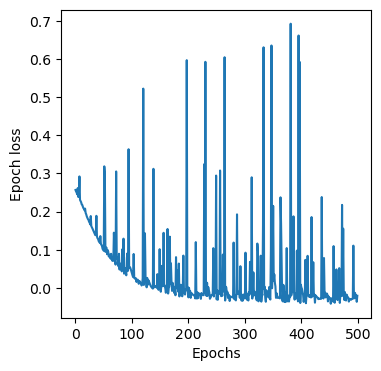

training_loss -0.02067460159195514
Average pos.mean:0.14604200422763824, Average pos_var: 0.0011192469391971827
(88,)

------------------Latent_dim:16	Exploration Step:5 ----------------------- 
88


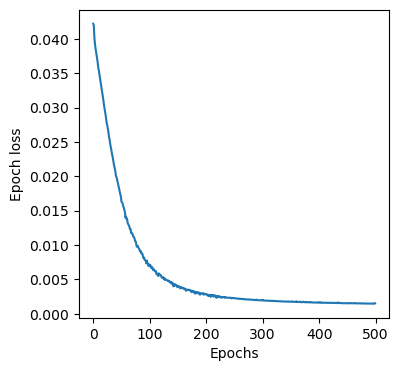

training_loss 0.0015125928210625427
Average pos.mean:0.15592750906944275, Average pos_var: 0.0002772889565676451
(91,)

------------------Latent_dim:16	Exploration Step:6 ----------------------- 
91


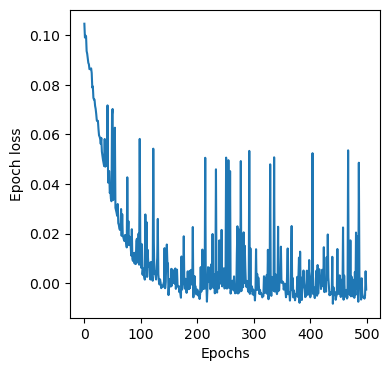

training_loss -0.0025294388520574413
Average pos.mean:0.15238161385059357, Average pos_var: 0.019182851538062096
(94,)

------------------Latent_dim:16	Exploration Step:7 ----------------------- 
94


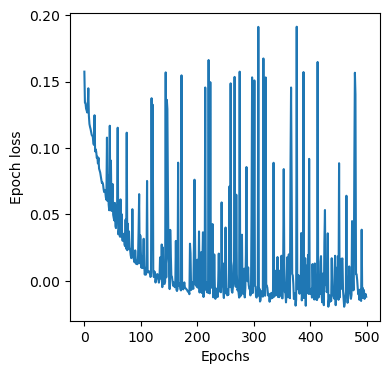

training_loss -0.012080319964165582
Average pos.mean:0.1306581199169159, Average pos_var: 0.000604296918027103
(97,)

------------------Latent_dim:16	Exploration Step:8 ----------------------- 
97


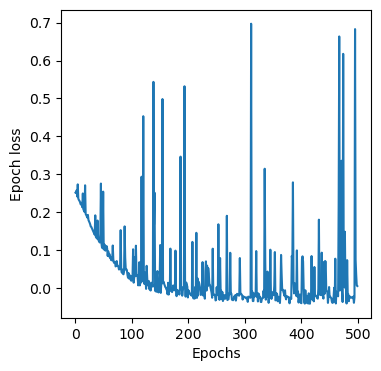

training_loss 0.005726182943913279
Average pos.mean:0.21577991545200348, Average pos_var: 0.0010600818786770105
(100,)

------------------Latent_dim:16	Exploration Step:9 ----------------------- 
100


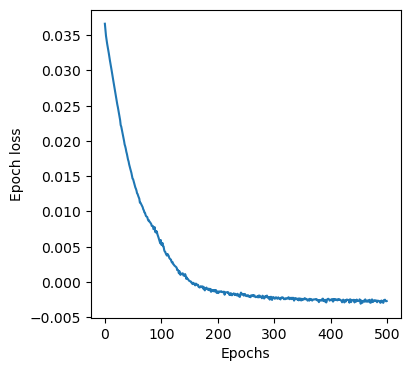

training_loss -0.002705968162904574
Average pos.mean:0.1359153836965561, Average pos_var: 0.008566529490053654
(103,)

------------------Latent_dim:16	Exploration Step:10 ----------------------- 
103


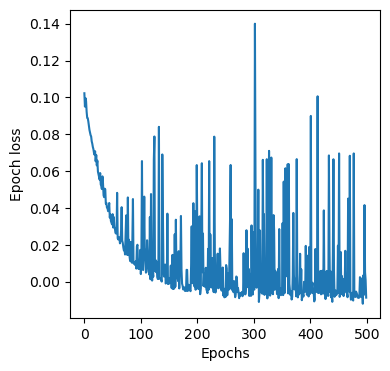

training_loss -0.008634405349977324
Average pos.mean:0.18116158246994019, Average pos_var: 0.0004666970926336944
(106,)
Intitial_dataset_score: tensor(93.2249)


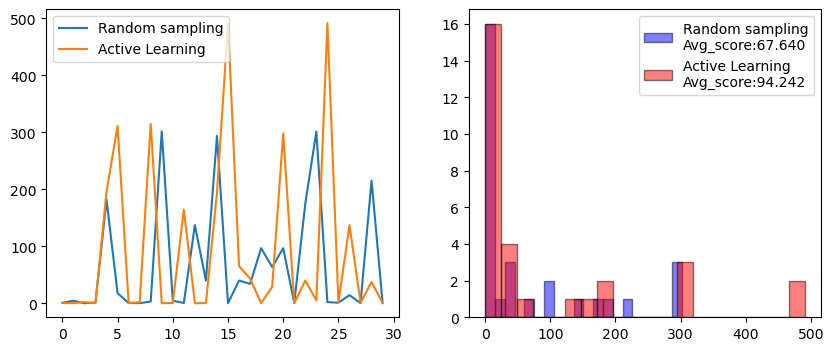

In [9]:

for latent_dim in latent_dims:
    
    # Initialize trainset

    train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, 
                                                                                                           indices, 
                                                                                                           test_size=initial_test_fraction, 
                                                                                                           random_state = random_state)
    
    initial_trainsize = train_indices.shape[0]

    train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)
    
    
    al_scores = []
    ran_scores = []

    for i in range(exploration_steps):

        print(f"\n------------------Latent_dim:{latent_dim}\tExploration Step:{i+1} ----------------------- ")

        custom_nn = MixedICCDNet(output_dim = latent_dim)

        device  = "cuda" if torch.cuda.is_available() else 'cpu'

        
        train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)
        print(len(train_dataset))

        # Contruct the GP surrogate function
        model, training_loss = train_mixed_nn_DKL(train_dataset, custom_nn,  lr_custom_nn = lr_custom_nn, lr_gp = lr_gp, num_epochs = n_epochs, device= device, n_batches = n_batches, plot_loss = True)

        torch.save(model.state_dict(), f'model_{i}.pt')
        
        print("training_loss", training_loss[-1])

        # Calculate the predicted posterior mean and variance
        y_means, y_vars = DKL_posterior(model, X, params = params)

        print(f"Average pos.mean:{y_means.mean()}, Average pos_var: {y_vars.mean()}")

        # Calculate the acquisition function
        #acq_ind, acq_val_max, Acq_vals = acq_fn_EI(y_means, y_vars, train_y, index_exclude= train_indices)

        beta = 0.3*beta
        acq_ind, acq_val_max, Acq_vals = acq_fn_UCB(y_means, y_vars, beta = beta, index_exclude= train_indices, sample_next_points = sample_next_points)

        # best estimates
        #X_best_train, X_best_pred = best_mean_estimate(train_X, train_y, X, y_means)


        for ind in acq_ind:

            # Acquire next point

            next_score = score[ind].detach().numpy().squeeze()
            al_scores.append(next_score)

            #randomly acquire
            ran_ind = random.choice(test_indices)
            ran_score = score[ran_ind].detach().numpy().squeeze()
            ran_scores.append(ran_score)


            #Update training data
            train_X, train_y, train_params, train_indices = append_to_train(X, y, params, train_X, train_y, train_params, 
                                                                            train_indices, ind)
            test_indices = np.delete(test_indices, np.where(test_indices == ind))



        print(train_indices.shape)

    al_scores = np.asarray(al_scores)
    ran_scores = np.asarray(ran_scores)
    
    
    # Save trainindices
    
    np.savetxt(os.path.join(save_folder, f'train_indices_ldim{latent_dim}.txt'), train_indices.T)
    
    
    # Savefigure
    fig, ax = plt.subplots(1, 2, figsize = (10, 4))

    print("Intitial_dataset_score:", score[train_indices[0:initial_trainsize]].mean())

    ax[0].plot(ran_scores, label = 'Random sampling')
    ax[0].plot(al_scores, label = 'Active Learning')
    ax[0].legend()

    ax[1].hist(ran_scores, bins=20, alpha=0.5, label=f'Random sampling\nAvg_score:{ran_scores.mean():.3f}', color='blue', edgecolor='black')
    ax[1].hist(al_scores, bins=20, alpha=0.5, label=f'Active Learning\nAvg_score:{al_scores.mean():.3f}', color='red', edgecolor='black')
    ax[1].legend()

    plt.savefig(os.path.join(save_folder, f'scorehist_ldim{latent_dim}.jpg'), bbox_inches = 'tight')
    plt.show()
    
    
    

# 2. DKL with RCNN

In [ ]:

datafile = 'data/PLD data.json'

# Get the dataset, for RCNN, the images_sequence is shaped as: (batch_size=127, seq_len=50, classes =1, width=40, height=40)
dataset1 = ICCDDataset(datafile, image_for_rcnn = True)


# Define the transform1
transform = transforms.RandomAffine(180,
                                    translate=(0.1,0.1),
                                    shear=10,
                                    scale=(0.8,1.2))
# Define the dataset with the transform
dataset2 = ICCDDataset(datafile, transform = transform, image_for_rcnn = True)


# Define the transform with Gaussian noise
transform_with_noise = transforms.Compose([
    transforms.RandomAffine(180, translate=(0.1, 0.1), shear=10, scale=(0.8, 1.2)),
    AddGaussianNoise(mean=0.0, std=0.1)
])

# Define the noise for parameters
param_noise = AddGaussianNoise(mean=0.0, std=0.1)

# Define the dataset with the transform and noise
dataset3 = ICCDDataset(datafile, transform=transform_with_noise, params_noise=param_noise, image_for_rcnn = True)


# Combine the datsets
dataset = ConcatDataset([dataset1, dataset2, dataset3])


In [7]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

X, orig_params, score,_ = extract_data(dataloader, norm = False)
X, params, y, indices = extract_data(dataloader)


In [8]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, indices, test_size=0.8, random_state=24)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)
test_dataset = TrainDataset(test_X, test_params, test_y, transform = None)

torch.Size([25, 50, 1, 40, 40]) torch.Size([25, 1]) torch.Size([102, 50, 1, 40, 40]) torch.Size([102, 1])


## Single step training

Using Mixed RCNN

latent_dim: 2


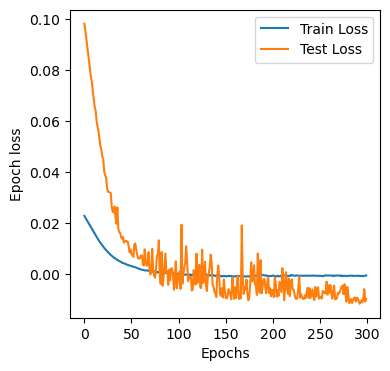

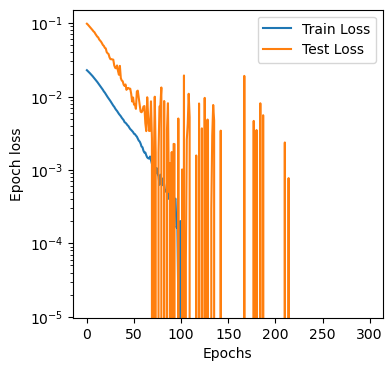

latent_dim: 3


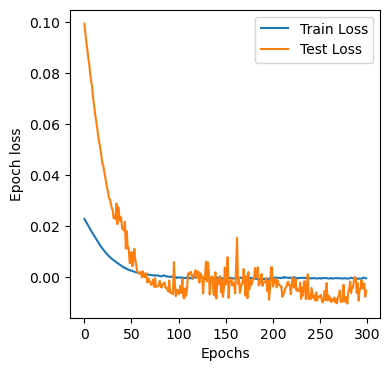

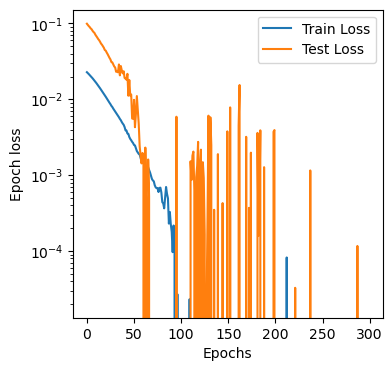

latent_dim: 6


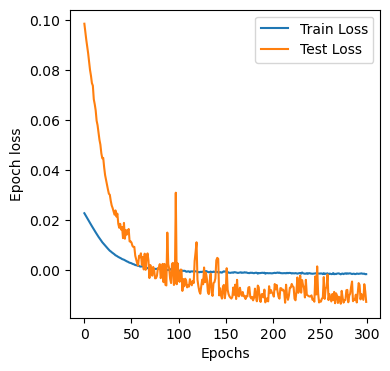

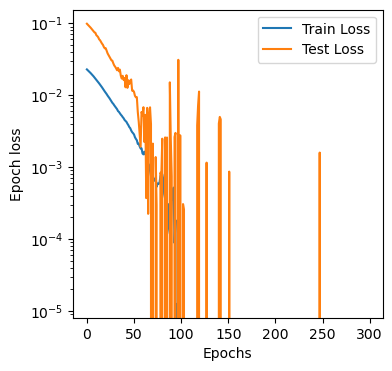

latent_dim: 8


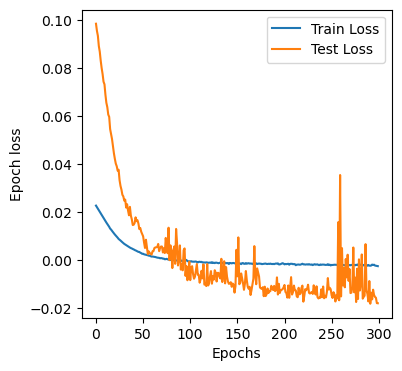

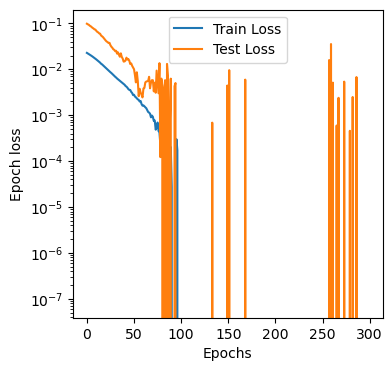

latent_dim: 10


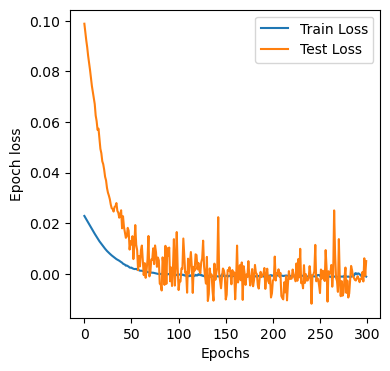

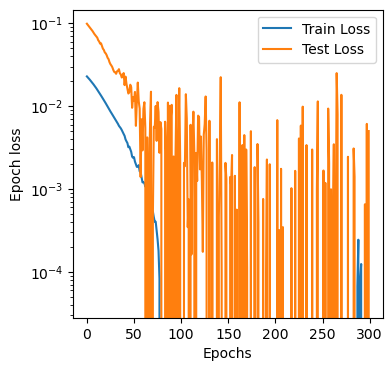

latent_dim: 16


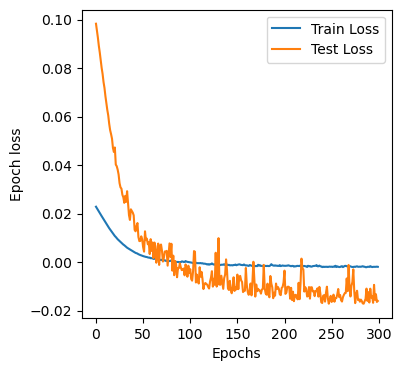

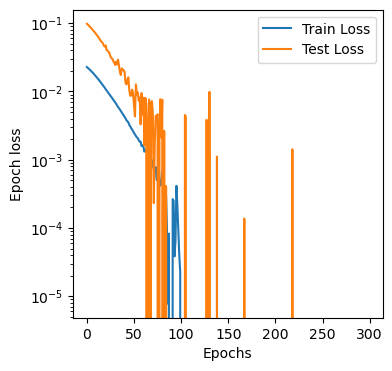

In [42]:
latent_dims = [2, 3, 6, 8, 10, 16]
n_epochs = 300
J_train = []
J_val = []

for latent_dim in latent_dims:

    train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, indices, test_size=0.2, random_state=24)


    train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)
    test_dataset = TrainDataset(test_X, test_params, test_y, transform = None)
    custom_nn = Mixed_RCNN_FeatureExtractor(output_dim = latent_dim)  

    print("latent_dim:", latent_dim)                                                                                                           
    model, training_loss, test_loss = train_test_mixed_nn_DKL(train_dataset, test_dataset, custom_nn, lr_custom_nn = 0.01, lr_gp = 0.01, num_epochs = n_epochs, plot_loss = True, n_batches = 8, weight_decay = 0)
    J_train.append(training_loss), J_val.append(test_loss)
    plot_training_loss(training_loss, test_loss)
        
                                                                                                          
                                                                                                           

Analyse train and val loss

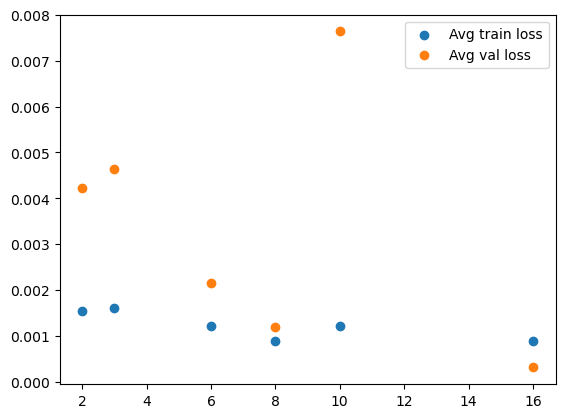

In [43]:
J_train = np.asarray(J_train)
J_val = np.asarray(J_val)

j_train = J_train[:, 0:].mean(axis = -1)
j_val = J_val[:, 0:].mean(axis = -1)

plt.scatter(latent_dims, j_train, label = "Avg train loss")
plt.scatter(latent_dims, j_val, label = "Avg val loss")
plt.legend()
plt.show()


In [18]:
y_means, y_vars = DKL_posterior(model, X, params = params)
y_means.shape, y_vars.shape


(torch.Size([381, 1]), torch.Size([381, 1]))

## Active Learning - Mixed RCNN

single active learning using Mixed RCNN

In [5]:
train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, indices, test_size=0.8, random_state=24)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)
initial_trainsize = train_indices.shape[0]


NameError: name 'train_test_split' is not defined

In [33]:
n_epochs = 500
n_batches = 4
sample_next_points = 3
beta = 0
lr_custom_nn = 0.01
lr_gp = 0.01


------------------Exploration Step:1 ----------------------- 



Training:  19%|███▍              | 97/500 [00:21<01:26,  4.66it/s, Loss=0.00762]


Training:  39%|██████▌          | 194/500 [00:43<01:05,  4.67it/s, Loss=0.00133]


Training:  58%|█████████▎      | 291/500 [01:06<01:00,  3.46it/s, Loss=0.000582]


Training:  78%|████████████▍   | 388/500 [01:28<00:26,  4.17it/s, Loss=0.000329]


Training:  97%|███████████████▌| 485/500 [01:50<00:03,  4.25it/s, Loss=0.000415]


Training: 100%|████████████████| 500/500 [01:54<00:00,  4.57it/s, Loss=-.000248]
                                                                                

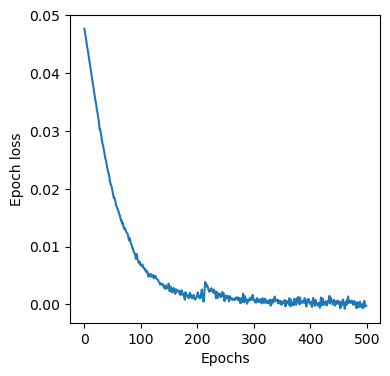

training_loss -0.0002483040796399747
Average pos.mean:0.17701569199562073, Average pos_var: 0.01679113879799843
(79,)

------------------Exploration Step:2 ----------------------- 



Training:  19%|███▍              | 97/500 [00:21<01:36,  4.19it/s, Loss=0.00866]


Training:  39%|███████▎           | 194/500 [00:44<01:24,  3.60it/s, Loss=0.001]


Training:  58%|█████████▉       | 291/500 [01:06<00:44,  4.69it/s, Loss=0.00016]


Training:  78%|█████████████▏   | 388/500 [01:27<00:24,  4.56it/s, Loss=-.00093]


Training:  97%|████████████████▍| 485/500 [01:49<00:03,  4.48it/s, Loss=0.00011]


Training: 100%|████████████████| 500/500 [01:52<00:00,  4.04it/s, Loss=-.000866]
                                                                                

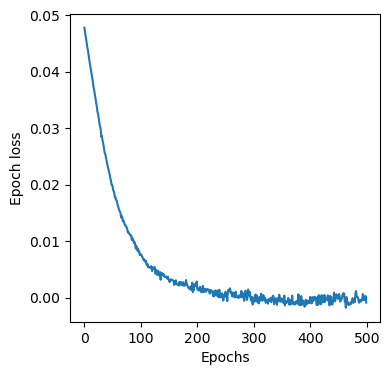

training_loss -0.0008656057182739277
Average pos.mean:0.2464883178472519, Average pos_var: 0.02435840480029583
(82,)

------------------Exploration Step:3 ----------------------- 



Training:  19%|███▍              | 97/500 [00:21<01:27,  4.62it/s, Loss=0.00704]


Training:  39%|██████▌          | 194/500 [00:43<01:17,  3.96it/s, Loss=0.00217]


Training:  58%|█████████▎      | 291/500 [01:05<00:44,  4.71it/s, Loss=-1.27e-5]


Training:  78%|█████████████▏   | 388/500 [01:27<00:25,  4.46it/s, Loss=0.00385]


Training:  97%|███████████████▌| 485/500 [01:50<00:04,  3.68it/s, Loss=0.000609]


Training: 100%|██████████████████| 500/500 [01:53<00:00,  4.23it/s, Loss=0.0012]
                                                                                

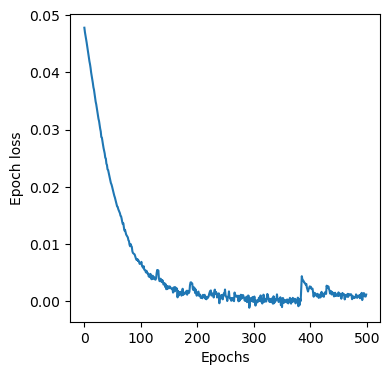

training_loss 0.0011951851809336128
Average pos.mean:0.15164683759212494, Average pos_var: 0.006777206901460886
(85,)

------------------Exploration Step:4 ----------------------- 



Training:  19%|███▍              | 97/500 [00:23<02:29,  2.70it/s, Loss=0.00884]


Training:  39%|██████▌          | 194/500 [00:50<01:09,  4.38it/s, Loss=0.00267]


Training:  58%|█████████▉       | 291/500 [01:14<01:10,  2.95it/s, Loss=0.00173]


Training:  78%|████████████▍   | 388/500 [01:36<00:22,  4.98it/s, Loss=0.000933]


Training:  97%|███████████████▌| 485/500 [01:57<00:03,  4.30it/s, Loss=0.000911]


Training: 100%|████████████████| 500/500 [02:00<00:00,  4.63it/s, Loss=0.000643]
                                                                                

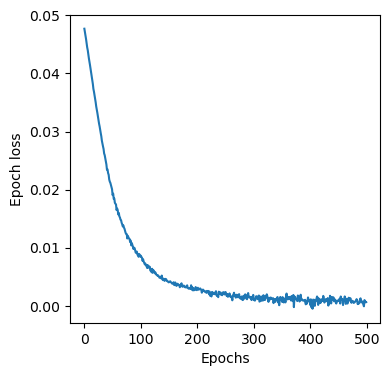

training_loss 0.0006429146478076593
Average pos.mean:0.1295703947544098, Average pos_var: 0.009360863827168941
(88,)

------------------Exploration Step:5 ----------------------- 



Training:  19%|███▍              | 97/500 [00:21<01:29,  4.49it/s, Loss=0.00822]


Training:  39%|██████▉           | 194/500 [00:43<01:04,  4.73it/s, Loss=0.0017]


Training:  58%|█████████▉       | 291/500 [01:03<00:45,  4.64it/s, Loss=0.00105]


Training:  78%|█████████████▏   | 388/500 [01:25<00:25,  4.40it/s, Loss=-.00129]


Training:  97%|███████████████▌| 485/500 [01:46<00:03,  4.50it/s, Loss=-8.64e-5]


Training: 100%|████████████████| 500/500 [01:49<00:00,  4.96it/s, Loss=-.000952]
                                                                                

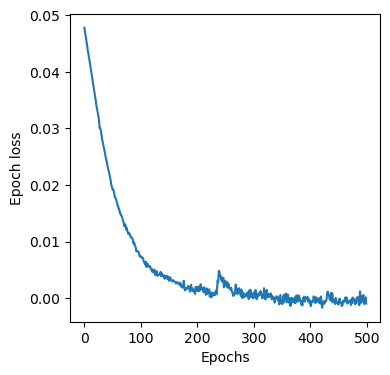

training_loss -0.000952319208378916
Average pos.mean:0.12048351764678955, Average pos_var: 0.013385393656790257
(91,)

------------------Exploration Step:6 ----------------------- 



Training:  19%|███▍              | 97/500 [00:21<01:27,  4.59it/s, Loss=0.00791]


Training:  39%|██████▌          | 194/500 [00:43<01:05,  4.66it/s, Loss=0.00155]


Training:  58%|█████████▎      | 291/500 [01:03<00:45,  4.59it/s, Loss=0.000563]


Training:  78%|████████████▍   | 388/500 [01:25<00:23,  4.81it/s, Loss=-.000136]


Training:  97%|███████████████▌| 485/500 [01:47<00:03,  4.44it/s, Loss=0.000473]


Training: 100%|████████████████| 500/500 [01:50<00:00,  4.84it/s, Loss=0.000552]
                                                                                

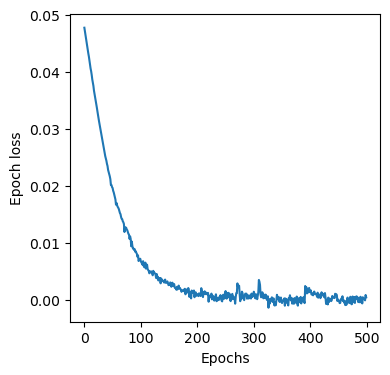

training_loss 0.0005518186737078681
Average pos.mean:0.1978245973587036, Average pos_var: 0.020063836127519608
(94,)

------------------Exploration Step:7 ----------------------- 



Training:  19%|███▋               | 97/500 [00:21<01:20,  4.99it/s, Loss=0.0077]


Training:  39%|██████▌          | 194/500 [00:42<01:02,  4.92it/s, Loss=0.00247]


Training:  58%|█████████▎      | 291/500 [01:03<00:42,  4.89it/s, Loss=0.000612]


Training:  78%|████████████▍   | 388/500 [01:25<00:26,  4.22it/s, Loss=-.000475]


Training:  97%|████████████████▍| 485/500 [01:47<00:03,  4.66it/s, Loss=-.00121]


Training: 100%|████████████████| 500/500 [01:50<00:00,  4.75it/s, Loss=-.000925]
                                                                                

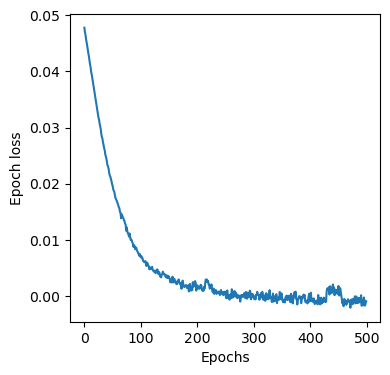

training_loss -0.0009248473391560357
Average pos.mean:0.1441265046596527, Average pos_var: 0.008995184674859047
(97,)

------------------Exploration Step:8 ----------------------- 



Training:  19%|███▍              | 97/500 [00:20<01:24,  4.79it/s, Loss=0.00745]


Training:  39%|██████▌          | 194/500 [00:42<01:03,  4.84it/s, Loss=0.00184]


Training:  58%|█████████▉       | 291/500 [01:04<00:49,  4.20it/s, Loss=-.00031]


Training:  78%|████████████▍   | 388/500 [01:25<00:23,  4.81it/s, Loss=-.000303]


Training:  97%|███████████████▌| 485/500 [01:46<00:03,  4.72it/s, Loss=-.000169]


Training: 100%|█████████████████| 500/500 [01:50<00:00,  5.04it/s, Loss=0.00183]
                                                                                

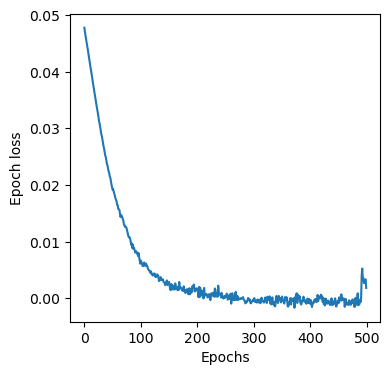

training_loss 0.0018326269636721958
Average pos.mean:0.16424182057380676, Average pos_var: 0.020297208800911903
(100,)

------------------Exploration Step:9 ----------------------- 



Training:  19%|███▍              | 97/500 [00:21<01:20,  4.98it/s, Loss=0.00859]


Training:  39%|██████▉           | 194/500 [00:43<01:01,  4.94it/s, Loss=0.0018]


Training:  58%|█████████▎      | 291/500 [01:05<00:42,  4.89it/s, Loss=0.000743]


Training:  78%|█████████████▏   | 388/500 [01:26<00:25,  4.31it/s, Loss=-.00028]


Training:  97%|███████████████▌| 485/500 [01:48<00:03,  4.34it/s, Loss=-.000478]


Training: 100%|█████████████████| 500/500 [01:52<00:00,  4.66it/s, Loss=0.00103]
                                                                                

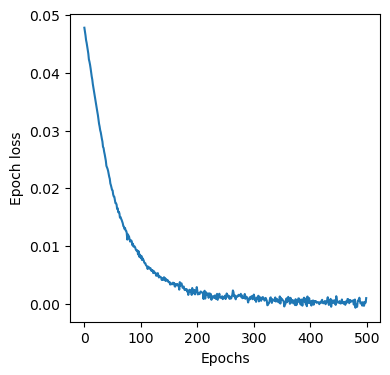

training_loss 0.001028216174879591
Average pos.mean:0.14361071586608887, Average pos_var: 0.010895660147070885
(103,)

------------------Exploration Step:10 ----------------------- 



Training:  19%|███▍              | 97/500 [00:22<01:26,  4.67it/s, Loss=0.00886]


Training:  39%|██████▌          | 194/500 [00:44<01:07,  4.56it/s, Loss=0.00381]


Training:  58%|█████████▉       | 291/500 [01:05<00:45,  4.62it/s, Loss=0.00281]


Training:  78%|█████████████▏   | 388/500 [01:26<00:27,  4.10it/s, Loss=0.00237]


Training:  97%|████████████████▍| 485/500 [01:48<00:03,  4.51it/s, Loss=0.00219]


Training: 100%|█████████████████| 500/500 [01:52<00:00,  3.79it/s, Loss=0.00216]
                                                                                

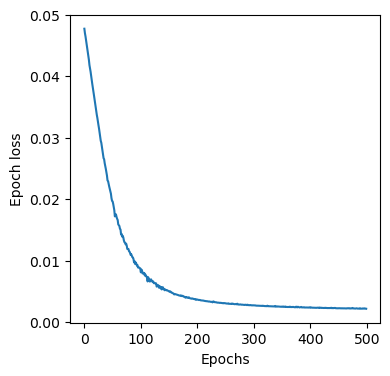

training_loss 0.0021560092487424506
Average pos.mean:0.15359023213386536, Average pos_var: 0.00029276072746142745
(106,)


In [34]:
#Set the number of exploration steps
exploration_steps = 10


al_scores = []
ran_scores = []

for i in range(exploration_steps):

    print(f"\n------------------Exploration Step:{i+1} ----------------------- ")

    custom_nn = Mixed_RCNN_FeatureExtractor(output_dim = 3)

    device  = "cuda" if torch.cuda.is_available() else 'cpu'

    
    train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)
    
    # Contruct the GP surrogate function
    model, training_loss = train_mixed_nn_DKL(train_dataset, custom_nn, lr_custom_nn = lr_custom_nn, lr_gp = lr_gp, num_epochs = n_epochs, device= device, n_batches = n_batches, plot_loss = True)
    print("training_loss", training_loss[-1])

    # Calculate the predicted posterior mean and variance
    y_means, y_vars = DKL_posterior(model, X, params = params)
    
    print(f"Average pos.mean:{y_means.mean()}, Average pos_var: {y_vars.mean()}")

    # Calculate the acquisition function
    #acq_ind, acq_val_max, Acq_vals = acq_fn_EI(y_means, y_vars, train_y, index_exclude= train_indices)
    
    
    acq_ind, acq_val_max, Acq_vals = acq_fn_UCB(y_means, y_vars, beta = beta, index_exclude= train_indices, sample_next_points = sample_next_points)
    beta = 0.5*beta
    
    # best estimates
    #X_best_train, X_best_pred = best_mean_estimate(train_X, train_y, X, y_means)
    

    for ind in acq_ind:
        
        # Acquire next point
        
        next_score = score[ind].detach().numpy().squeeze()
        al_scores.append(next_score)
        
        
        ran_ind = random.choice(test_indices)
        ran_score = score[ran_ind].detach().numpy().squeeze()
        ran_scores.append(ran_score)
        
#         print("Next-index: ",ind)
#         print("Measured score: ", next_score)

        #Update training data
        train_X, train_y, train_params, train_indices = append_to_train(X, y, params, train_X, train_y, train_params, train_indices, ind)
        test_indices = np.delete(test_indices, np.where(test_indices == ind))
                                 
                                 
                                 
    print(train_indices.shape)
    
al_scores = np.asarray(al_scores)
ran_scores = np.asarray(ran_scores)
    

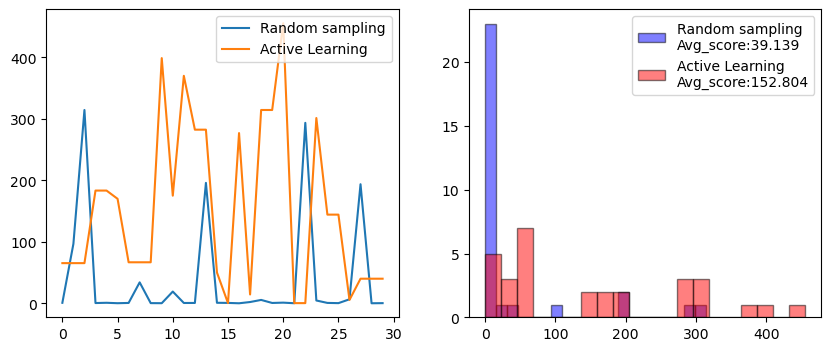

In [35]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4))

ax[0].plot(ran_scores, label = 'Random sampling')
ax[0].plot(al_scores, label = 'Active Learning')
ax[0].legend()

ax[1].hist(ran_scores, bins=20, alpha=0.5, label=f'Random sampling\nAvg_score:{ran_scores.mean():.3f}', color='blue', edgecolor='black')
ax[1].hist(al_scores, bins=20, alpha=0.5, label=f'Active Learning\nAvg_score:{al_scores.mean():.3f}', color='red', edgecolor='black')
ax[1].legend()

plt.show()


GP Training:  73%|██████████▏   | 183/250 [00:01<00:00, 164.23it/s, Loss=0.0272]


GP Training: 100%|██████████████| 250/250 [00:01<00:00, 164.78it/s, Loss=0.0248]
                                                                                

training_loss 0.00028800448879253034


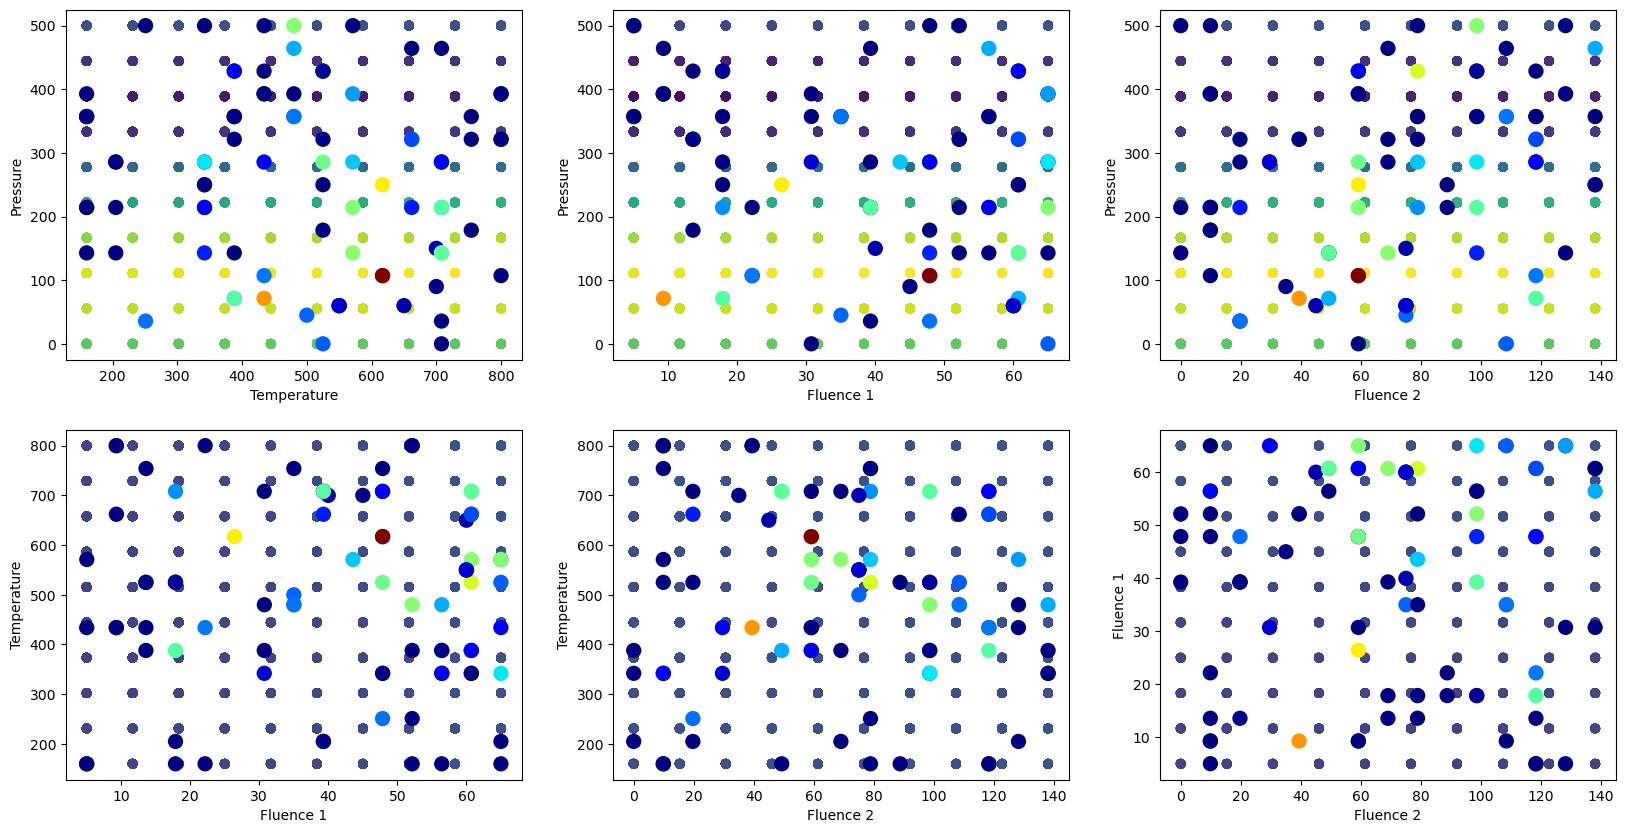

In [28]:
# train_params = params[train_indices]

# y_GPmean, _, _ = parameter_mapping(train_params, train_y, orig_params, param_divs = [10, 10, 10, 10], plot_GP = True, num_epochs = 250)


## Active learning loop - Mixed LSTMCNN

In [11]:
train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, 
                                                                                                           indices, 
                                                                                                           test_size=0.8, 
                                                                                                           random_state=24)

initial_trainsize = train_indices.shape[0]

train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)

print(len(train_dataset))


n_epochs = 500
n_batches = 4
sample_next_points = 1
beta = 1000
decay_fac = 0.8
lr_custom_nn = 0.01
lr_gp = 0.01
initial_test_fraction = 0.8
random_state = 24


#Set the number of exploration steps
exploration_steps = 50

latent_dims = [6]

 
expt_name = "18_Mixed_LSTMCNN_realAL_betadecay"
save_folder = os.path.join("data", expt_name)
os.makedirs(save_folder, exist_ok=True)


25


In [12]:
def augmented_dataset(images, params, score):
    
    dataset1 = TrainDataset(images, params, score, transform = None)
    
    
    # Define the transform2
    transform2 = transforms.RandomAffine(180,
                                    translate=(0.1,0.1),
                                    shear=10,
                                    scale=(0.8,1.2))
    
    dataset2 = TrainDataset(images, params, score, transform = transform2)
    
    
    # Define the transform2
    transform3 = transforms.Compose([
                        transforms.RandomAffine(180, translate=(0.1, 0.1), shear=10, scale=(0.8, 1.2)),
                        AddGaussianNoise(mean=0.0, std=0.1)
                    ])
    
    dataset3 = TrainDataset(images, params, score, transform = transform3)
    
    
    # Combine the datsets
    dataset = ConcatDataset([dataset1, dataset2, dataset3])
    
    return dataset


------------------Latent_dim:6	Exploration Step:1 ----------------------- 
75


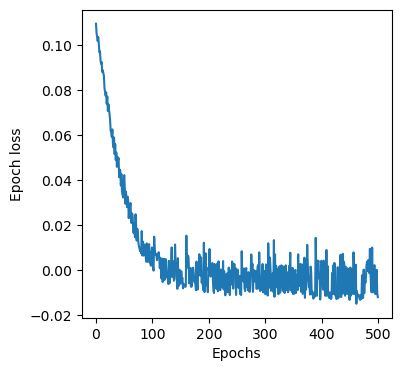

training_loss -0.012172291644525485
Average pos.mean:0.11482543498277664, Average pos_var: 0.008838805370032787
(26,)

------------------Latent_dim:6	Exploration Step:2 ----------------------- 
78


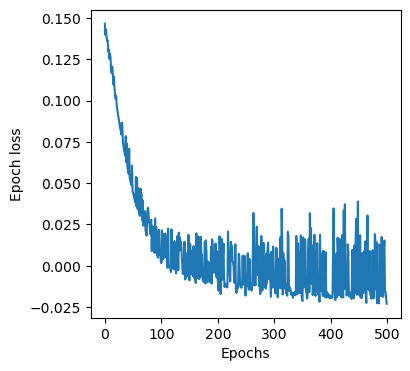

training_loss -0.023010304891229818
Average pos.mean:0.1059965118765831, Average pos_var: 0.004430133383721113
(27,)

------------------Latent_dim:6	Exploration Step:3 ----------------------- 
81


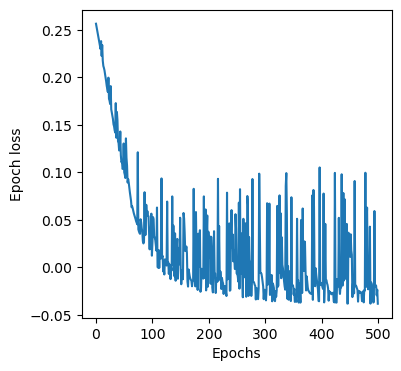

training_loss -0.03825567955872779
Average pos.mean:0.1234852597117424, Average pos_var: 0.00961699616163969
(28,)

------------------Latent_dim:6	Exploration Step:4 ----------------------- 
84


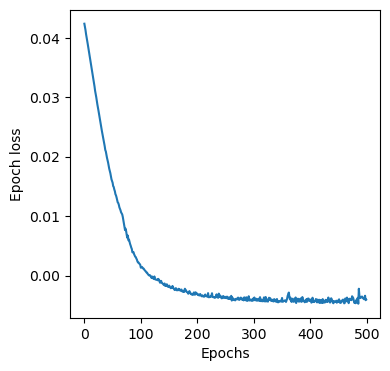

training_loss -0.004058133692736347
Average pos.mean:0.13617724180221558, Average pos_var: 0.006999134551733732
(29,)

------------------Latent_dim:6	Exploration Step:5 ----------------------- 
87


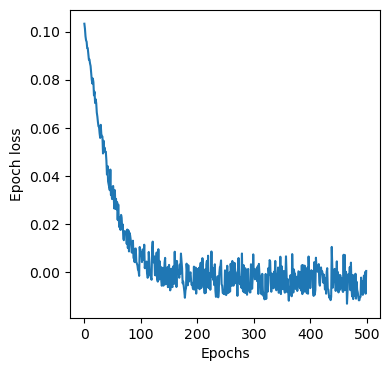

training_loss 0.0004085002235296689
Average pos.mean:0.15241417288780212, Average pos_var: 0.014436840079724789
(30,)

------------------Latent_dim:6	Exploration Step:6 ----------------------- 
90


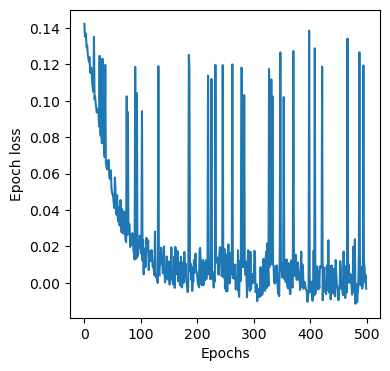

training_loss -0.0032798737629171557
Average pos.mean:0.1772596389055252, Average pos_var: 0.02091953344643116
(31,)

------------------Latent_dim:6	Exploration Step:7 ----------------------- 
93


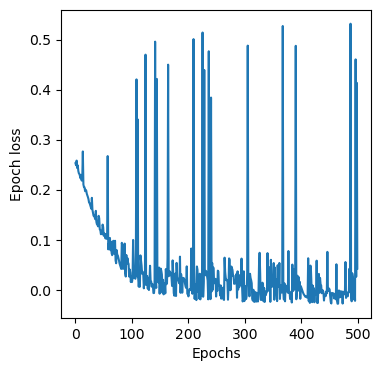

training_loss 0.04259132871713667
Average pos.mean:0.25088033080101013, Average pos_var: 0.02054903469979763
(32,)

------------------Latent_dim:6	Exploration Step:8 ----------------------- 
96


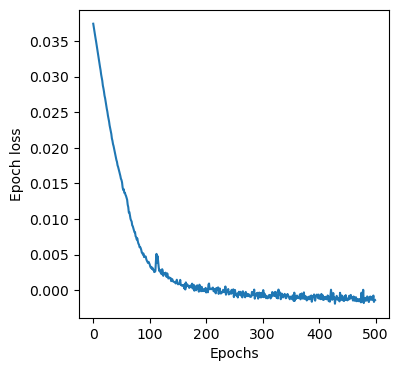

training_loss -0.0013651563721543752
Average pos.mean:0.12112537026405334, Average pos_var: 0.008816155605018139
(33,)

------------------Latent_dim:6	Exploration Step:9 ----------------------- 
99


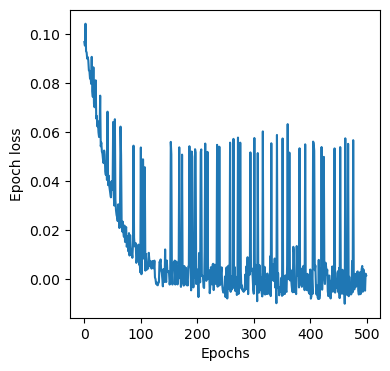

training_loss 0.001667985872330741
Average pos.mean:0.14220072329044342, Average pos_var: 0.01347282063215971
(34,)

------------------Latent_dim:6	Exploration Step:10 ----------------------- 
102


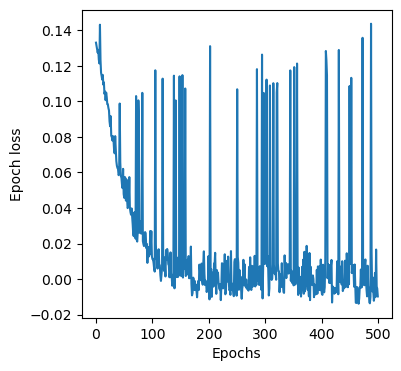

training_loss -0.009755474468531722
Average pos.mean:0.13645906746387482, Average pos_var: 0.013478738255798817
(35,)

------------------Latent_dim:6	Exploration Step:11 ----------------------- 
105


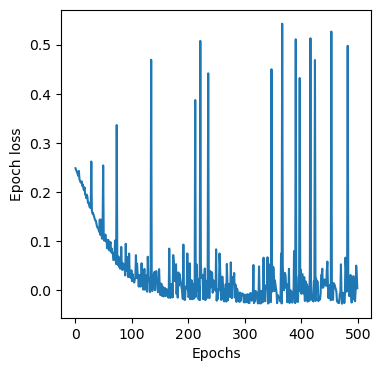

training_loss 0.003717786043617588
Average pos.mean:0.17403246462345123, Average pos_var: 0.017196079716086388
(36,)

------------------Latent_dim:6	Exploration Step:12 ----------------------- 
108


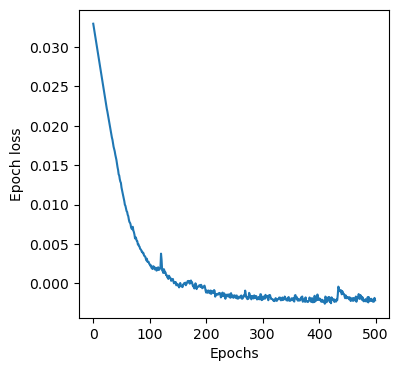

training_loss -0.0021386514843551377
Average pos.mean:0.14643138647079468, Average pos_var: 0.007041464559733868
(37,)

------------------Latent_dim:6	Exploration Step:13 ----------------------- 
111


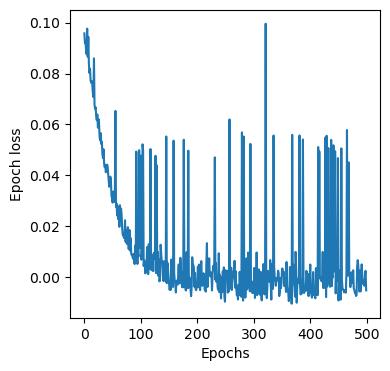

training_loss -0.0053560339412103315
Average pos.mean:0.1474839746952057, Average pos_var: 0.014971697703003883
(38,)

------------------Latent_dim:6	Exploration Step:14 ----------------------- 
114


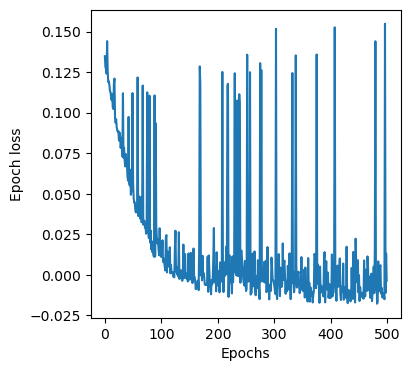

training_loss -0.0036437924285629363
Average pos.mean:0.1713649332523346, Average pos_var: 0.008821802213788033
(39,)

------------------Latent_dim:6	Exploration Step:15 ----------------------- 
117


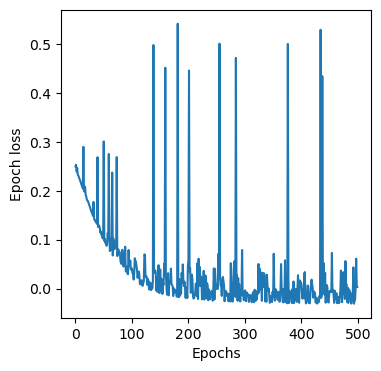

training_loss 0.0031556840634675704
Average pos.mean:0.17770500481128693, Average pos_var: 0.015255345962941647
(40,)

------------------Latent_dim:6	Exploration Step:16 ----------------------- 
120


training_loss -0.0021374418938604964
Average pos.mean:0.13203254342079163, Average pos_var: 0.007815113291144371
(41,)

------------------Latent_dim:6	Exploration Step:17 ----------------------- 
123


training_loss 0.00123831119233795
Average pos.mean:0.1776401400566101, Average pos_var: 0.013742879033088684
(42,)

------------------Latent_dim:6	Exploration Step:18 ----------------------- 
126


training_loss 0.010261252338754521
Average pos.mean:0.2436772733926773, Average pos_var: 0.020548881962895393
(43,)

------------------Latent_dim:6	Exploration Step:19 ----------------------- 
129


training_loss 0.00940166964335359
Average pos.mean:0.24873217940330505, Average pos_var: 0.01697208732366562
(44,)

------------------Latent_dim:6	Exploration Step:20 ----------------------- 
132


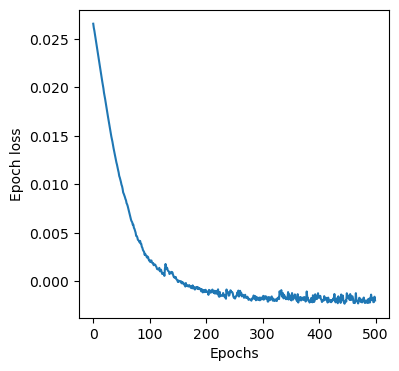

training_loss -0.0019563062837512496
Average pos.mean:0.10543010383844376, Average pos_var: 0.00673316465690732
(45,)

------------------Latent_dim:6	Exploration Step:21 ----------------------- 
135


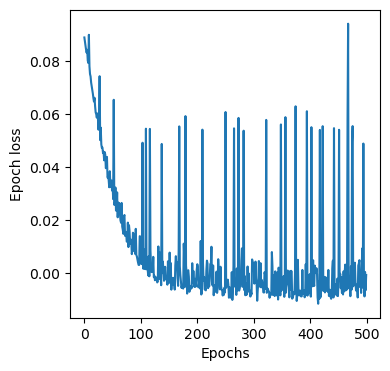

training_loss -0.0007987823853883673
Average pos.mean:0.1875784993171692, Average pos_var: 0.014135316014289856
(46,)

------------------Latent_dim:6	Exploration Step:22 ----------------------- 
138


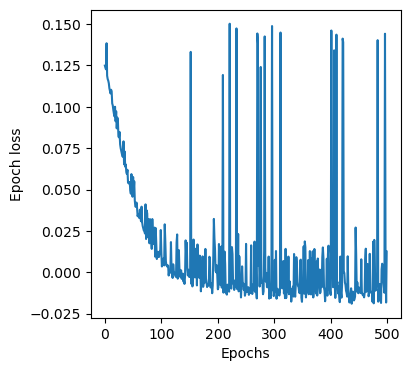

training_loss 0.012509150074904019
Average pos.mean:0.19248583912849426, Average pos_var: 0.00964459776878357
(47,)

------------------Latent_dim:6	Exploration Step:23 ----------------------- 
141


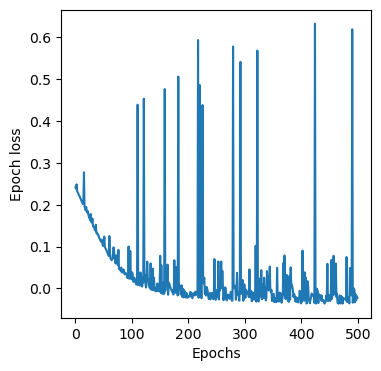

training_loss -0.021855374539901547
Average pos.mean:0.12382784485816956, Average pos_var: 0.009002001024782658
(48,)

------------------Latent_dim:6	Exploration Step:24 ----------------------- 
144


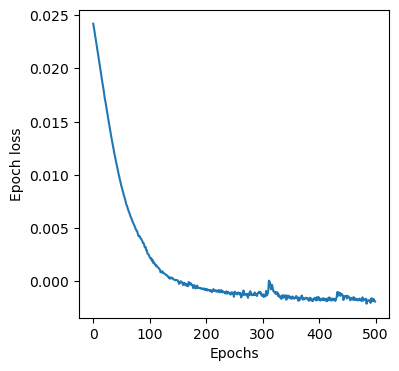

training_loss -0.001877518341573671
Average pos.mean:0.14095494151115417, Average pos_var: 0.007842152379453182
(49,)

------------------Latent_dim:6	Exploration Step:25 ----------------------- 
147


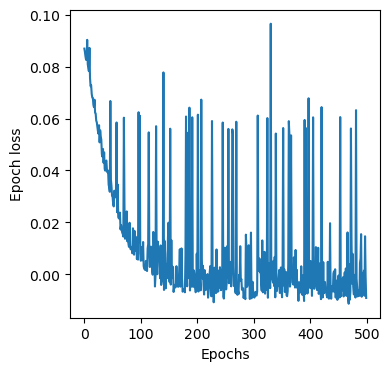

training_loss -0.009114027953667607
Average pos.mean:0.17708440124988556, Average pos_var: 0.011635846458375454
(50,)

------------------Latent_dim:6	Exploration Step:26 ----------------------- 
150


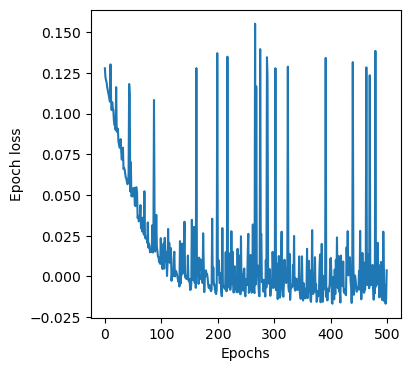

training_loss 0.0037985193519073325
Average pos.mean:0.21370266377925873, Average pos_var: 0.014370830729603767
(51,)

------------------Latent_dim:6	Exploration Step:27 ----------------------- 
153


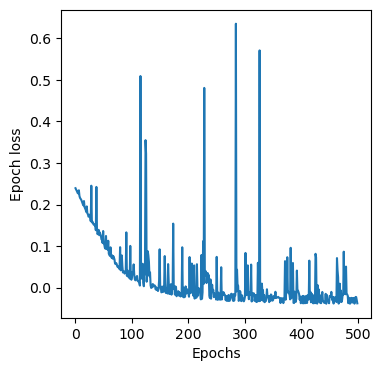

training_loss -0.0377555491599951
Average pos.mean:0.14645378291606903, Average pos_var: 0.00730304466560483
(52,)

------------------Latent_dim:6	Exploration Step:28 ----------------------- 
156


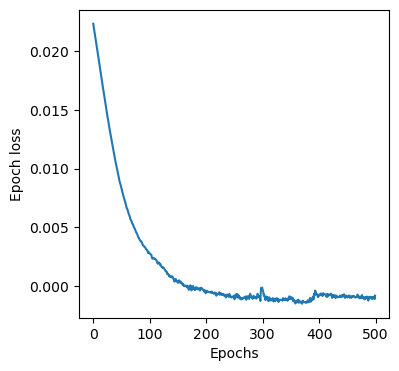

training_loss -0.000822432050938552
Average pos.mean:0.14010053873062134, Average pos_var: 0.00448671355843544
(53,)

------------------Latent_dim:6	Exploration Step:29 ----------------------- 
159


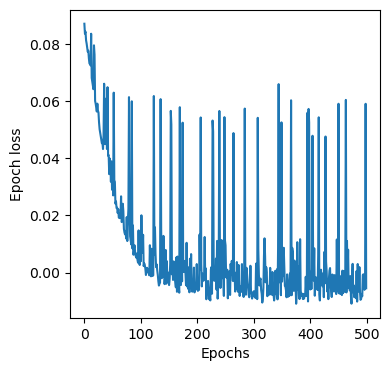

training_loss -0.005494583582694221
Average pos.mean:0.1472068727016449, Average pos_var: 0.011444531381130219
(54,)

------------------Latent_dim:6	Exploration Step:30 ----------------------- 
162


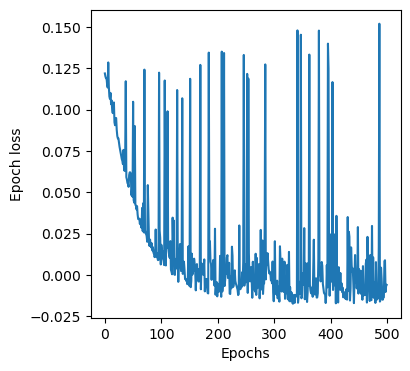

training_loss -0.0059411688821332295
Average pos.mean:0.15327848494052887, Average pos_var: 0.009341795928776264
(55,)

------------------Latent_dim:6	Exploration Step:31 ----------------------- 
165


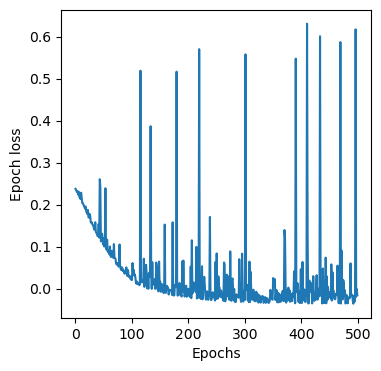

training_loss -0.015658821158236
Average pos.mean:0.18680331110954285, Average pos_var: 0.01042379904538393
(56,)

------------------Latent_dim:6	Exploration Step:32 ----------------------- 
168


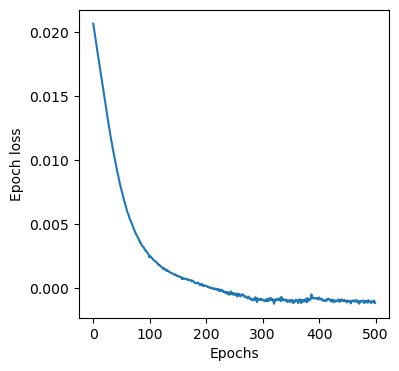

training_loss -0.0011476964991054398
Average pos.mean:0.12194905430078506, Average pos_var: 0.004406479652971029
(57,)

------------------Latent_dim:6	Exploration Step:33 ----------------------- 
171


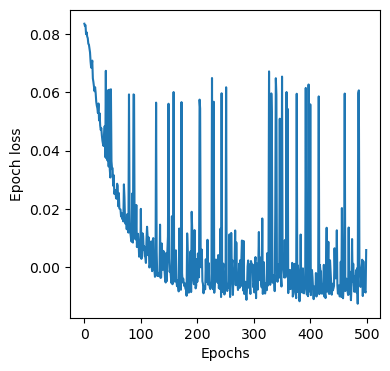

training_loss 0.005838163185352288
Average pos.mean:0.14950357377529144, Average pos_var: 0.010493261739611626
(58,)

------------------Latent_dim:6	Exploration Step:34 ----------------------- 
174


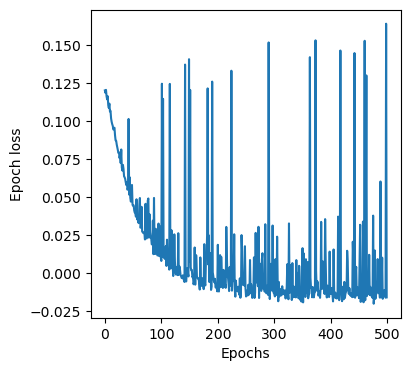

training_loss -0.015772640837714076
Average pos.mean:0.13859382271766663, Average pos_var: 0.0061080437153577805
(59,)

------------------Latent_dim:6	Exploration Step:35 ----------------------- 
177


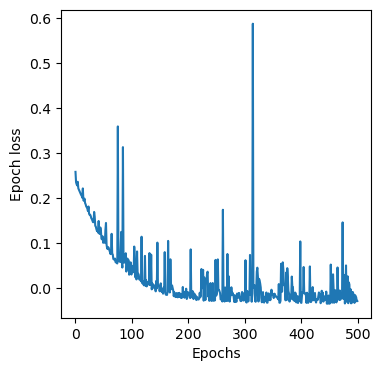

training_loss -0.02871443588779445
Average pos.mean:0.11976543813943863, Average pos_var: 0.012396741658449173
(60,)

------------------Latent_dim:6	Exploration Step:36 ----------------------- 
180


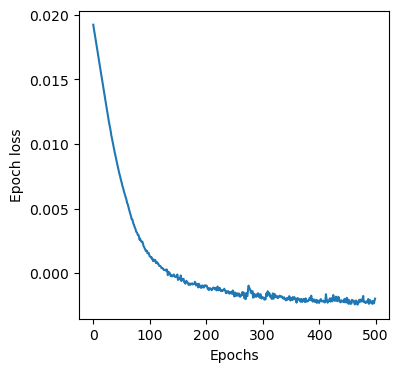

training_loss -0.001975063628662996
Average pos.mean:0.12861771881580353, Average pos_var: 0.004514897242188454
(61,)

------------------Latent_dim:6	Exploration Step:37 ----------------------- 
183


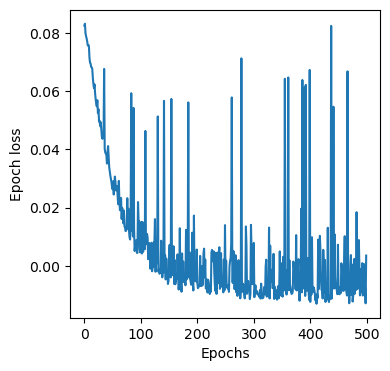

training_loss 0.0035284247342601675
Average pos.mean:0.15488417446613312, Average pos_var: 0.006033544894307852
(62,)

------------------Latent_dim:6	Exploration Step:38 ----------------------- 
186


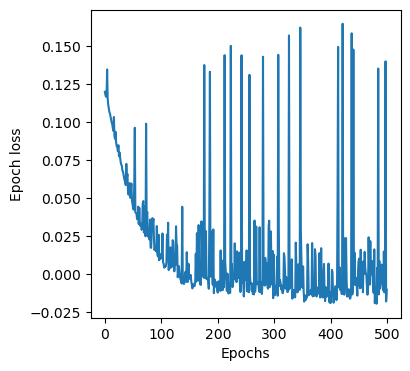

training_loss -0.010358229692604677
Average pos.mean:0.20875293016433716, Average pos_var: 0.007403731346130371
(63,)

------------------Latent_dim:6	Exploration Step:39 ----------------------- 
189


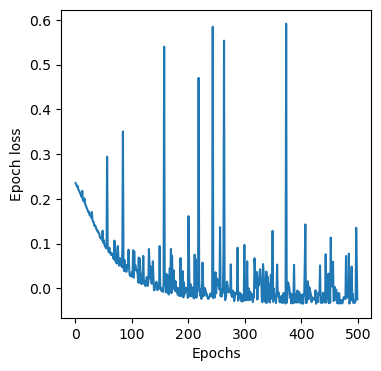

training_loss -0.024992595736061884
Average pos.mean:0.2168039083480835, Average pos_var: 0.011823051609098911
(64,)

------------------Latent_dim:6	Exploration Step:40 ----------------------- 
192


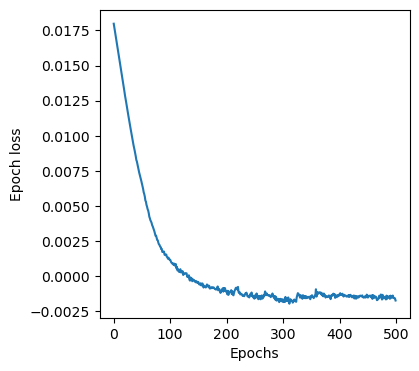

training_loss -0.0017260185428110279
Average pos.mean:0.10264573246240616, Average pos_var: 0.008519090712070465
(65,)

------------------Latent_dim:6	Exploration Step:41 ----------------------- 
195


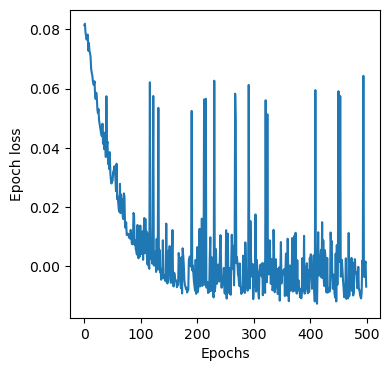

training_loss -0.006898800119123784
Average pos.mean:0.1499110907316208, Average pos_var: 0.008803966455161572
(66,)

------------------Latent_dim:6	Exploration Step:42 ----------------------- 
198


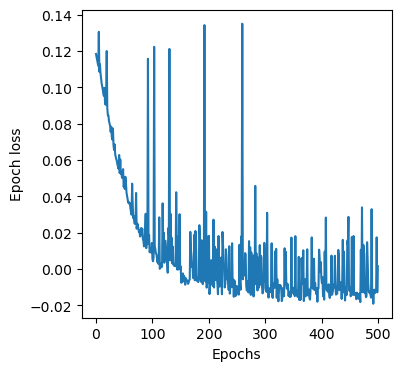

training_loss 0.0014841734531749911
Average pos.mean:0.1623951494693756, Average pos_var: 0.009534372016787529
(67,)

------------------Latent_dim:6	Exploration Step:43 ----------------------- 
201


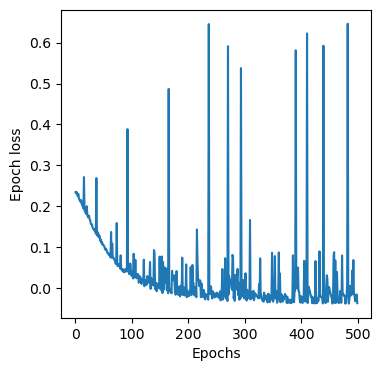

training_loss -0.03704408927264537
Average pos.mean:0.14506293833255768, Average pos_var: 0.0075617143884301186
(68,)

------------------Latent_dim:6	Exploration Step:44 ----------------------- 
204


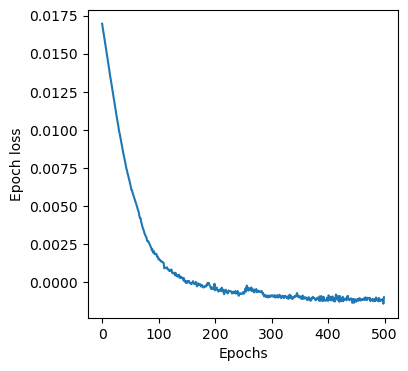

training_loss -0.000977726071820124
Average pos.mean:0.12027128785848618, Average pos_var: 0.003831351175904274
(69,)

------------------Latent_dim:6	Exploration Step:45 ----------------------- 
207


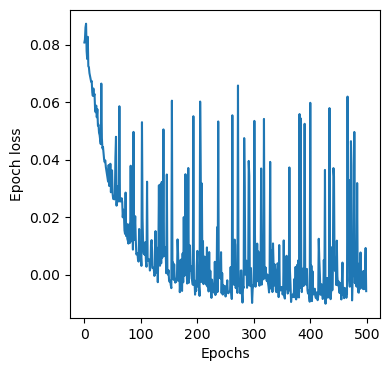

training_loss -0.00572958917870379
Average pos.mean:0.16871769726276398, Average pos_var: 0.014591983519494534
(70,)

------------------Latent_dim:6	Exploration Step:46 ----------------------- 
210


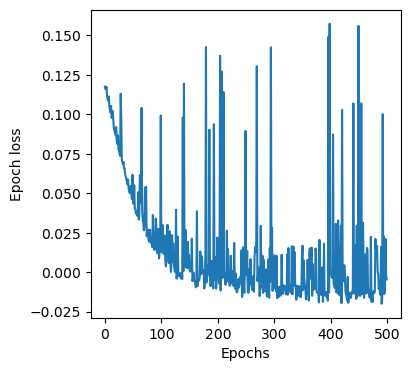

training_loss -0.004525854486744841
Average pos.mean:0.1732112020254135, Average pos_var: 0.0049207983538508415
(71,)

------------------Latent_dim:6	Exploration Step:47 ----------------------- 
213


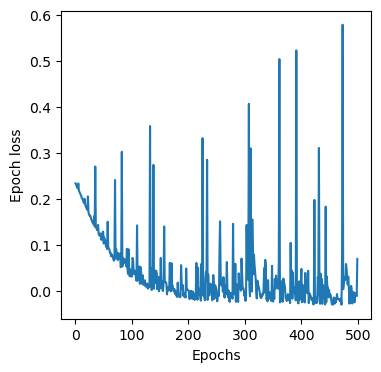

training_loss 0.06958172108148977
Average pos.mean:0.1501101851463318, Average pos_var: 0.019028278067708015
(72,)

------------------Latent_dim:6	Exploration Step:48 ----------------------- 
216


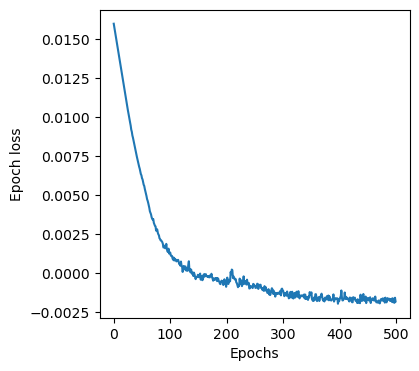

training_loss -0.0018219221475521312
Average pos.mean:0.04048137739300728, Average pos_var: 0.007467125542461872
(73,)

------------------Latent_dim:6	Exploration Step:49 ----------------------- 
219


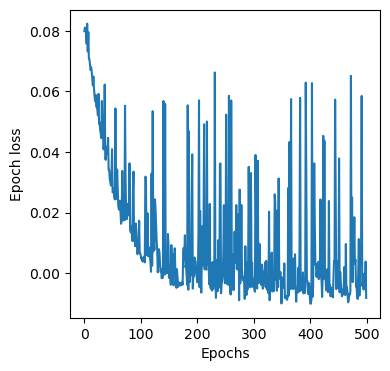

training_loss -0.008153382701775978
Average pos.mean:0.1563311219215393, Average pos_var: 0.013033696450293064
(74,)

------------------Latent_dim:6	Exploration Step:50 ----------------------- 
222


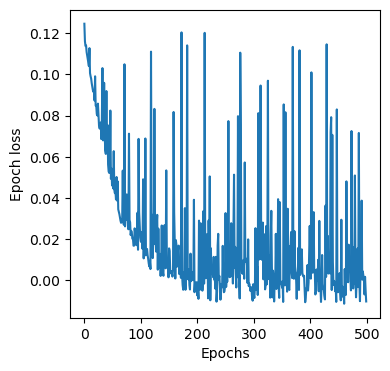

training_loss -0.010349873456283423
Average pos.mean:0.16572916507720947, Average pos_var: 0.0217518862336874
(75,)
Intitial_dataset_score: tensor(75.9067)


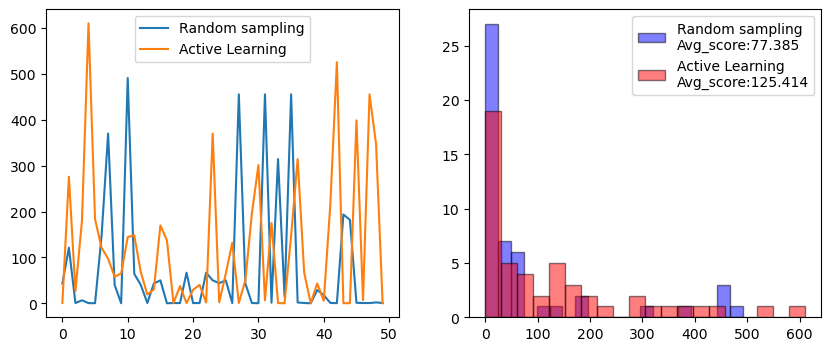

In [13]:

for latent_dim in latent_dims:
    
    # Initialize trainset

    train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, 
                                                                                                           indices, 
                                                                                                           test_size=initial_test_fraction, 
                                                                                                           random_state = random_state)
    
    initial_trainsize = train_indices.shape[0]

#     #train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)
    
#     #trainset x3 
#     train_dataset = augmented_dataset(train_X, train_params, train_y)
#     print(len(train_dataset))
    
    
    al_scores = []
    ran_scores = []

    for i in range(exploration_steps):

        print(f"\n------------------Latent_dim:{latent_dim}\tExploration Step:{i+1} ----------------------- ")

        
        custom_nn = Mixed_LSTM_FeatureExtractor(output_dim = latent_dim)

        
        device  = "cuda" if torch.cuda.is_available() else 'cpu'

        
        #train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)
        
        #trainset x3 
        train_dataset = augmented_dataset(train_X, train_params, train_y)
        print(len(train_dataset))

        # Contruct the GP surrogate function
        model, training_loss = train_mixed_nn_DKL(train_dataset, custom_nn,  lr_custom_nn = lr_custom_nn, lr_gp = lr_gp, 
                                                  num_epochs = n_epochs, device= device, n_batches = n_batches, 
                                                  plot_loss = True)

        print("training_loss", training_loss[-1])

        # Calculate the predicted posterior mean and variance
        y_means, y_vars = DKL_posterior(model, X, params = params)

        print(f"Average pos.mean:{y_means.mean()}, Average pos_var: {y_vars.mean()}")

        # Calculate the acquisition function
        #acq_ind, acq_val_max, Acq_vals = acq_fn_EI(y_means, y_vars, train_y, index_exclude= train_indices)

        
        acq_ind, acq_val_max, Acq_vals = acq_fn_UCB(y_means, y_vars, beta = beta, index_exclude= train_indices, 
                                                    sample_next_points = sample_next_points)
        
        beta = beta*decay_fac

        # best estimates
        #X_best_train, X_best_pred = best_mean_estimate(train_X, train_y, X, y_means)


        for ind in acq_ind:

            # Acquire next point

            next_score = score[ind].detach().numpy().squeeze()
            al_scores.append(next_score)

            #randomly acquire
            ran_ind = random.choice(test_indices)
            ran_score = score[ran_ind].detach().numpy().squeeze()
            ran_scores.append(ran_score)


            #Update training data
            train_X, train_y, train_params, train_indices = append_to_train(X, y, params, train_X, train_y, train_params, 
                                                                            train_indices, ind)
            test_indices = np.delete(test_indices, np.where(test_indices == ind))



        print(train_indices.shape)

    al_scores = np.asarray(al_scores)
    ran_scores = np.asarray(ran_scores)
    
    
    # Save trainindices
    
    np.savetxt(os.path.join(save_folder, f'train_indices_ldim{latent_dim}.txt'), train_indices.T)
    
    
    # Savefigure
    fig, ax = plt.subplots(1, 2, figsize = (10, 4))

    print("Intitial_dataset_score:", score[train_indices[0:initial_trainsize]].mean())

    ax[0].plot(ran_scores, label = 'Random sampling')
    ax[0].plot(al_scores, label = 'Active Learning')
    ax[0].legend()

    ax[1].hist(ran_scores, bins=20, alpha=0.5, label=f'Random sampling\nAvg_score:{ran_scores.mean():.3f}', color='blue', edgecolor='black')
    ax[1].hist(al_scores, bins=20, alpha=0.5, label=f'Active Learning\nAvg_score:{al_scores.mean():.3f}', color='red', edgecolor='black')
    ax[1].legend()

    plt.savefig(os.path.join(save_folder, f'scorehist_ldim{latent_dim}.jpg'), bbox_inches = 'tight')
    plt.show()
    
    
    